# Miller age

In [1]:
ood_seed = 13

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Lung secretory cells', '21.0'), 438)


Removed datapoint: 438

train         5592
validation    1375
ood            438
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 101645.24it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 1067020.10it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 187.32it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:02<15:44,  2.37s/it]

Epoch 1/400:   0%|          | 1/400 [00:02<15:44,  2.37s/it, v_num=1, recon=1.16e+3, r2_mean=0.0652, adv_loss=3.55, acc_pert=0.318, acc_integration_donor=0.0988]

Epoch 2/400:   0%|          | 1/400 [00:02<15:44,  2.37s/it, v_num=1, recon=1.16e+3, r2_mean=0.0652, adv_loss=3.55, acc_pert=0.318, acc_integration_donor=0.0988]

Epoch 2/400:   0%|          | 2/400 [00:04<15:07,  2.28s/it, v_num=1, recon=1.16e+3, r2_mean=0.0652, adv_loss=3.55, acc_pert=0.318, acc_integration_donor=0.0988]

Epoch 2/400:   0%|          | 2/400 [00:04<15:07,  2.28s/it, v_num=1, recon=988, r2_mean=0.304, adv_loss=3.14, acc_pert=0.464, acc_integration_donor=0.295]      

Epoch 3/400:   0%|          | 2/400 [00:04<15:07,  2.28s/it, v_num=1, recon=988, r2_mean=0.304, adv_loss=3.14, acc_pert=0.464, acc_integration_donor=0.295]

Epoch 3/400:   1%|          | 3/400 [00:06<14:54,  2.25s/it, v_num=1, recon=988, r2_mean=0.304, adv_loss=3.14, acc_pert=0.464, acc_integration_donor=0.295]

Epoch 3/400:   1%|          | 3/400 [00:06<14:54,  2.25s/it, v_num=1, recon=922, r2_mean=0.406, adv_loss=2.84, acc_pert=0.523, acc_integration_donor=0.461]

Epoch 4/400:   1%|          | 3/400 [00:06<14:54,  2.25s/it, v_num=1, recon=922, r2_mean=0.406, adv_loss=2.84, acc_pert=0.523, acc_integration_donor=0.461]

Epoch 4/400:   1%|          | 4/400 [00:09<14:46,  2.24s/it, v_num=1, recon=922, r2_mean=0.406, adv_loss=2.84, acc_pert=0.523, acc_integration_donor=0.461]

Epoch 4/400:   1%|          | 4/400 [00:09<14:46,  2.24s/it, v_num=1, recon=888, r2_mean=0.44, adv_loss=2.65, acc_pert=0.527, acc_integration_donor=0.515] 

Epoch 5/400:   1%|          | 4/400 [00:09<14:46,  2.24s/it, v_num=1, recon=888, r2_mean=0.44, adv_loss=2.65, acc_pert=0.527, acc_integration_donor=0.515]

Epoch 5/400:   1%|▏         | 5/400 [00:11<14:33,  2.21s/it, v_num=1, recon=888, r2_mean=0.44, adv_loss=2.65, acc_pert=0.527, acc_integration_donor=0.515]

Epoch 5/400:   1%|▏         | 5/400 [00:11<14:33,  2.21s/it, v_num=1, recon=871, r2_mean=0.463, adv_loss=2.49, acc_pert=0.547, acc_integration_donor=0.53]

Epoch 6/400:   1%|▏         | 5/400 [00:11<14:33,  2.21s/it, v_num=1, recon=871, r2_mean=0.463, adv_loss=2.49, acc_pert=0.547, acc_integration_donor=0.53]

Epoch 6/400:   2%|▏         | 6/400 [00:13<14:32,  2.21s/it, v_num=1, recon=871, r2_mean=0.463, adv_loss=2.49, acc_pert=0.547, acc_integration_donor=0.53]

Epoch 6/400:   2%|▏         | 6/400 [00:13<14:32,  2.21s/it, v_num=1, recon=859, r2_mean=0.471, adv_loss=2.36, acc_pert=0.548, acc_integration_donor=0.546]

Epoch 7/400:   2%|▏         | 6/400 [00:13<14:32,  2.21s/it, v_num=1, recon=859, r2_mean=0.471, adv_loss=2.36, acc_pert=0.548, acc_integration_donor=0.546]

Epoch 7/400:   2%|▏         | 7/400 [00:15<14:23,  2.20s/it, v_num=1, recon=859, r2_mean=0.471, adv_loss=2.36, acc_pert=0.548, acc_integration_donor=0.546]

Epoch 7/400:   2%|▏         | 7/400 [00:15<14:23,  2.20s/it, v_num=1, recon=851, r2_mean=0.479, adv_loss=2.27, acc_pert=0.569, acc_integration_donor=0.555]

Epoch 8/400:   2%|▏         | 7/400 [00:15<14:23,  2.20s/it, v_num=1, recon=851, r2_mean=0.479, adv_loss=2.27, acc_pert=0.569, acc_integration_donor=0.555]

Epoch 8/400:   2%|▏         | 8/400 [00:17<14:14,  2.18s/it, v_num=1, recon=851, r2_mean=0.479, adv_loss=2.27, acc_pert=0.569, acc_integration_donor=0.555]

Epoch 8/400:   2%|▏         | 8/400 [00:17<14:14,  2.18s/it, v_num=1, recon=844, r2_mean=0.485, adv_loss=2.22, acc_pert=0.56, acc_integration_donor=0.556] 

Epoch 9/400:   2%|▏         | 8/400 [00:17<14:14,  2.18s/it, v_num=1, recon=844, r2_mean=0.485, adv_loss=2.22, acc_pert=0.56, acc_integration_donor=0.556]

Epoch 9/400:   2%|▏         | 9/400 [00:19<14:09,  2.17s/it, v_num=1, recon=844, r2_mean=0.485, adv_loss=2.22, acc_pert=0.56, acc_integration_donor=0.556]

Epoch 9/400:   2%|▏         | 9/400 [00:19<14:09,  2.17s/it, v_num=1, recon=839, r2_mean=0.493, adv_loss=2.22, acc_pert=0.575, acc_integration_donor=0.553]

Epoch 10/400:   2%|▏         | 9/400 [00:19<14:09,  2.17s/it, v_num=1, recon=839, r2_mean=0.493, adv_loss=2.22, acc_pert=0.575, acc_integration_donor=0.553]


disnt_basal = 0.5137224948854976

disnt_after = 0.9062695231567666

val_r2_mean = 0.5043981122699651

val_r2_var = 0.1814035868102854


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:23<16:47,  2.58s/it, v_num=1, recon=839, r2_mean=0.493, adv_loss=2.22, acc_pert=0.575, acc_integration_donor=0.553]

Epoch 10/400:   2%|▎         | 10/400 [00:23<16:47,  2.58s/it, v_num=1, recon=834, r2_mean=0.499, adv_loss=2.24, acc_pert=0.571, acc_integration_donor=0.546, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:23<16:47,  2.58s/it, v_num=1, recon=834, r2_mean=0.499, adv_loss=2.24, acc_pert=0.571, acc_integration_donor=0.546, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:25<16:40,  2.57s/it, v_num=1, recon=834, r2_mean=0.499, adv_loss=2.24, acc_pert=0.571, acc_integration_donor=0.546, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:25<16:40,  2.57s/it, v_num=1, recon=829, r2_mean=0.506, adv_loss=2.25, acc_pert=0.565, acc_integration_donor=0.535, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:25<16:40,  2.57s/it, v_num=1, recon=829, r2_mean=0.506, adv_loss=2.25, acc_pert=0.565, acc_integration_donor=0.535, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:28<15:40,  2.42s/it, v_num=1, recon=829, r2_mean=0.506, adv_loss=2.25, acc_pert=0.565, acc_integration_donor=0.535, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:28<15:40,  2.42s/it, v_num=1, recon=826, r2_mean=0.508, adv_loss=2.21, acc_pert=0.567, acc_integration_donor=0.543, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:28<15:40,  2.42s/it, v_num=1, recon=826, r2_mean=0.508, adv_loss=2.21, acc_pert=0.567, acc_integration_donor=0.543, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:30<15:07,  2.34s/it, v_num=1, recon=826, r2_mean=0.508, adv_loss=2.21, acc_pert=0.567, acc_integration_donor=0.543, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:30<15:07,  2.34s/it, v_num=1, recon=822, r2_mean=0.506, adv_loss=2.22, acc_pert=0.576, acc_integration_donor=0.533, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:30<15:07,  2.34s/it, v_num=1, recon=822, r2_mean=0.506, adv_loss=2.22, acc_pert=0.576, acc_integration_donor=0.533, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:32<14:40,  2.28s/it, v_num=1, recon=822, r2_mean=0.506, adv_loss=2.22, acc_pert=0.576, acc_integration_donor=0.533, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:32<14:40,  2.28s/it, v_num=1, recon=819, r2_mean=0.513, adv_loss=2.23, acc_pert=0.567, acc_integration_donor=0.53, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan] 

Epoch 15/400:   4%|▎         | 14/400 [00:32<14:40,  2.28s/it, v_num=1, recon=819, r2_mean=0.513, adv_loss=2.23, acc_pert=0.567, acc_integration_donor=0.53, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:34<14:32,  2.27s/it, v_num=1, recon=819, r2_mean=0.513, adv_loss=2.23, acc_pert=0.567, acc_integration_donor=0.53, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:34<14:32,  2.27s/it, v_num=1, recon=816, r2_mean=0.514, adv_loss=2.22, acc_pert=0.56, acc_integration_donor=0.537, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [00:34<14:32,  2.27s/it, v_num=1, recon=816, r2_mean=0.514, adv_loss=2.22, acc_pert=0.56, acc_integration_donor=0.537, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:36<14:17,  2.23s/it, v_num=1, recon=816, r2_mean=0.514, adv_loss=2.22, acc_pert=0.56, acc_integration_donor=0.537, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:36<14:17,  2.23s/it, v_num=1, recon=814, r2_mean=0.52, adv_loss=2.21, acc_pert=0.567, acc_integration_donor=0.532, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [00:36<14:17,  2.23s/it, v_num=1, recon=814, r2_mean=0.52, adv_loss=2.21, acc_pert=0.567, acc_integration_donor=0.532, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:38<14:13,  2.23s/it, v_num=1, recon=814, r2_mean=0.52, adv_loss=2.21, acc_pert=0.567, acc_integration_donor=0.532, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:38<14:13,  2.23s/it, v_num=1, recon=811, r2_mean=0.523, adv_loss=2.22, acc_pert=0.562, acc_integration_donor=0.537, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:38<14:13,  2.23s/it, v_num=1, recon=811, r2_mean=0.523, adv_loss=2.22, acc_pert=0.562, acc_integration_donor=0.537, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:41<14:06,  2.22s/it, v_num=1, recon=811, r2_mean=0.523, adv_loss=2.22, acc_pert=0.562, acc_integration_donor=0.537, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:41<14:06,  2.22s/it, v_num=1, recon=809, r2_mean=0.525, adv_loss=2.19, acc_pert=0.582, acc_integration_donor=0.537, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [00:41<14:06,  2.22s/it, v_num=1, recon=809, r2_mean=0.525, adv_loss=2.19, acc_pert=0.582, acc_integration_donor=0.537, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:43<14:01,  2.21s/it, v_num=1, recon=809, r2_mean=0.525, adv_loss=2.19, acc_pert=0.582, acc_integration_donor=0.537, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:43<14:01,  2.21s/it, v_num=1, recon=807, r2_mean=0.528, adv_loss=2.2, acc_pert=0.573, acc_integration_donor=0.539, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan] 

Epoch 20/400:   5%|▍         | 19/400 [00:43<14:01,  2.21s/it, v_num=1, recon=807, r2_mean=0.528, adv_loss=2.2, acc_pert=0.573, acc_integration_donor=0.539, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]


disnt_basal = 0.506972276085823

disnt_after = 0.8781228891842269

val_r2_mean = 0.508294362236153

val_r2_var = 0.28880288722840225


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [00:46<16:32,  2.61s/it, v_num=1, recon=807, r2_mean=0.528, adv_loss=2.2, acc_pert=0.573, acc_integration_donor=0.539, val_recon=848, disnt_basal=0.514, disnt_after=0.906, val_r2_mean=0.504, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [00:46<16:32,  2.61s/it, v_num=1, recon=806, r2_mean=0.529, adv_loss=2.18, acc_pert=0.579, acc_integration_donor=0.54, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [00:46<16:32,  2.61s/it, v_num=1, recon=806, r2_mean=0.529, adv_loss=2.18, acc_pert=0.579, acc_integration_donor=0.54, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [00:49<15:47,  2.50s/it, v_num=1, recon=806, r2_mean=0.529, adv_loss=2.18, acc_pert=0.579, acc_integration_donor=0.54, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [00:49<15:47,  2.50s/it, v_num=1, recon=804, r2_mean=0.531, adv_loss=2.2, acc_pert=0.571, acc_integration_donor=0.538, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [00:49<15:47,  2.50s/it, v_num=1, recon=804, r2_mean=0.531, adv_loss=2.2, acc_pert=0.571, acc_integration_donor=0.538, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [00:51<15:05,  2.39s/it, v_num=1, recon=804, r2_mean=0.531, adv_loss=2.2, acc_pert=0.571, acc_integration_donor=0.538, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [00:51<15:05,  2.39s/it, v_num=1, recon=802, r2_mean=0.533, adv_loss=2.22, acc_pert=0.564, acc_integration_donor=0.532, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [00:51<15:05,  2.39s/it, v_num=1, recon=802, r2_mean=0.533, adv_loss=2.22, acc_pert=0.564, acc_integration_donor=0.532, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [00:53<14:44,  2.35s/it, v_num=1, recon=802, r2_mean=0.533, adv_loss=2.22, acc_pert=0.564, acc_integration_donor=0.532, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [00:53<14:44,  2.35s/it, v_num=1, recon=801, r2_mean=0.53, adv_loss=2.22, acc_pert=0.561, acc_integration_donor=0.534, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan] 

Epoch 24/400:   6%|▌         | 23/400 [00:53<14:44,  2.35s/it, v_num=1, recon=801, r2_mean=0.53, adv_loss=2.22, acc_pert=0.561, acc_integration_donor=0.534, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [00:55<14:29,  2.31s/it, v_num=1, recon=801, r2_mean=0.53, adv_loss=2.22, acc_pert=0.561, acc_integration_donor=0.534, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [00:55<14:29,  2.31s/it, v_num=1, recon=798, r2_mean=0.539, adv_loss=2.2, acc_pert=0.564, acc_integration_donor=0.527, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [00:55<14:29,  2.31s/it, v_num=1, recon=798, r2_mean=0.539, adv_loss=2.2, acc_pert=0.564, acc_integration_donor=0.527, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [00:57<14:23,  2.30s/it, v_num=1, recon=798, r2_mean=0.539, adv_loss=2.2, acc_pert=0.564, acc_integration_donor=0.527, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [00:57<14:23,  2.30s/it, v_num=1, recon=798, r2_mean=0.537, adv_loss=2.21, acc_pert=0.56, acc_integration_donor=0.534, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [00:57<14:23,  2.30s/it, v_num=1, recon=798, r2_mean=0.537, adv_loss=2.21, acc_pert=0.56, acc_integration_donor=0.534, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:00<13:59,  2.25s/it, v_num=1, recon=798, r2_mean=0.537, adv_loss=2.21, acc_pert=0.56, acc_integration_donor=0.534, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:00<13:59,  2.25s/it, v_num=1, recon=796, r2_mean=0.539, adv_loss=2.23, acc_pert=0.554, acc_integration_donor=0.527, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:00<13:59,  2.25s/it, v_num=1, recon=796, r2_mean=0.539, adv_loss=2.23, acc_pert=0.554, acc_integration_donor=0.527, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:02<13:55,  2.24s/it, v_num=1, recon=796, r2_mean=0.539, adv_loss=2.23, acc_pert=0.554, acc_integration_donor=0.527, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:02<13:55,  2.24s/it, v_num=1, recon=795, r2_mean=0.541, adv_loss=2.2, acc_pert=0.567, acc_integration_donor=0.537, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan] 

Epoch 28/400:   7%|▋         | 27/400 [01:02<13:55,  2.24s/it, v_num=1, recon=795, r2_mean=0.541, adv_loss=2.2, acc_pert=0.567, acc_integration_donor=0.537, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:04<13:51,  2.23s/it, v_num=1, recon=795, r2_mean=0.541, adv_loss=2.2, acc_pert=0.567, acc_integration_donor=0.537, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:04<13:51,  2.23s/it, v_num=1, recon=793, r2_mean=0.547, adv_loss=2.23, acc_pert=0.546, acc_integration_donor=0.533, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:04<13:51,  2.23s/it, v_num=1, recon=793, r2_mean=0.547, adv_loss=2.23, acc_pert=0.546, acc_integration_donor=0.533, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:06<13:44,  2.22s/it, v_num=1, recon=793, r2_mean=0.547, adv_loss=2.23, acc_pert=0.546, acc_integration_donor=0.533, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:06<13:44,  2.22s/it, v_num=1, recon=793, r2_mean=0.545, adv_loss=2.23, acc_pert=0.54, acc_integration_donor=0.537, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan] 

Epoch 30/400:   7%|▋         | 29/400 [01:06<13:44,  2.22s/it, v_num=1, recon=793, r2_mean=0.545, adv_loss=2.23, acc_pert=0.54, acc_integration_donor=0.537, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]


disnt_basal = 0.49993513499609354

disnt_after = 0.8792983310344851

val_r2_mean = 0.509299211204052

val_r2_var = 0.3159979378635233


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:10<16:07,  2.61s/it, v_num=1, recon=793, r2_mean=0.545, adv_loss=2.23, acc_pert=0.54, acc_integration_donor=0.537, val_recon=821, disnt_basal=0.507, disnt_after=0.878, val_r2_mean=0.508, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:10<16:07,  2.61s/it, v_num=1, recon=791, r2_mean=0.547, adv_loss=2.22, acc_pert=0.567, acc_integration_donor=0.529, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan] 

Epoch 31/400:   8%|▊         | 30/400 [01:10<16:07,  2.61s/it, v_num=1, recon=791, r2_mean=0.547, adv_loss=2.22, acc_pert=0.567, acc_integration_donor=0.529, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:12<15:20,  2.49s/it, v_num=1, recon=791, r2_mean=0.547, adv_loss=2.22, acc_pert=0.567, acc_integration_donor=0.529, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:12<15:20,  2.49s/it, v_num=1, recon=790, r2_mean=0.547, adv_loss=2.22, acc_pert=0.545, acc_integration_donor=0.537, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [01:12<15:20,  2.49s/it, v_num=1, recon=790, r2_mean=0.547, adv_loss=2.22, acc_pert=0.545, acc_integration_donor=0.537, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:14<14:39,  2.39s/it, v_num=1, recon=790, r2_mean=0.547, adv_loss=2.22, acc_pert=0.545, acc_integration_donor=0.537, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:14<14:39,  2.39s/it, v_num=1, recon=789, r2_mean=0.547, adv_loss=2.22, acc_pert=0.558, acc_integration_donor=0.527, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [01:14<14:39,  2.39s/it, v_num=1, recon=789, r2_mean=0.547, adv_loss=2.22, acc_pert=0.558, acc_integration_donor=0.527, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:16<14:12,  2.32s/it, v_num=1, recon=789, r2_mean=0.547, adv_loss=2.22, acc_pert=0.558, acc_integration_donor=0.527, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:16<14:12,  2.32s/it, v_num=1, recon=787, r2_mean=0.551, adv_loss=2.23, acc_pert=0.541, acc_integration_donor=0.523, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [01:16<14:12,  2.32s/it, v_num=1, recon=787, r2_mean=0.551, adv_loss=2.23, acc_pert=0.541, acc_integration_donor=0.523, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:18<13:56,  2.29s/it, v_num=1, recon=787, r2_mean=0.551, adv_loss=2.23, acc_pert=0.541, acc_integration_donor=0.523, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:18<13:56,  2.29s/it, v_num=1, recon=787, r2_mean=0.552, adv_loss=2.25, acc_pert=0.547, acc_integration_donor=0.53, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan] 

Epoch 35/400:   8%|▊         | 34/400 [01:18<13:56,  2.29s/it, v_num=1, recon=787, r2_mean=0.552, adv_loss=2.25, acc_pert=0.547, acc_integration_donor=0.53, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:21<13:45,  2.26s/it, v_num=1, recon=787, r2_mean=0.552, adv_loss=2.25, acc_pert=0.547, acc_integration_donor=0.53, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:21<13:45,  2.26s/it, v_num=1, recon=784, r2_mean=0.552, adv_loss=2.24, acc_pert=0.54, acc_integration_donor=0.535, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [01:21<13:45,  2.26s/it, v_num=1, recon=784, r2_mean=0.552, adv_loss=2.24, acc_pert=0.54, acc_integration_donor=0.535, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:23<13:28,  2.22s/it, v_num=1, recon=784, r2_mean=0.552, adv_loss=2.24, acc_pert=0.54, acc_integration_donor=0.535, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:23<13:28,  2.22s/it, v_num=1, recon=785, r2_mean=0.553, adv_loss=2.24, acc_pert=0.534, acc_integration_donor=0.531, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [01:23<13:28,  2.22s/it, v_num=1, recon=785, r2_mean=0.553, adv_loss=2.24, acc_pert=0.534, acc_integration_donor=0.531, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:25<13:21,  2.21s/it, v_num=1, recon=785, r2_mean=0.553, adv_loss=2.24, acc_pert=0.534, acc_integration_donor=0.531, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:25<13:21,  2.21s/it, v_num=1, recon=783, r2_mean=0.552, adv_loss=2.25, acc_pert=0.549, acc_integration_donor=0.526, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [01:25<13:21,  2.21s/it, v_num=1, recon=783, r2_mean=0.552, adv_loss=2.25, acc_pert=0.549, acc_integration_donor=0.526, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:27<13:08,  2.18s/it, v_num=1, recon=783, r2_mean=0.552, adv_loss=2.25, acc_pert=0.549, acc_integration_donor=0.526, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:27<13:08,  2.18s/it, v_num=1, recon=781, r2_mean=0.55, adv_loss=2.25, acc_pert=0.539, acc_integration_donor=0.537, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan] 

Epoch 39/400:  10%|▉         | 38/400 [01:27<13:08,  2.18s/it, v_num=1, recon=781, r2_mean=0.55, adv_loss=2.25, acc_pert=0.539, acc_integration_donor=0.537, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:29<13:07,  2.18s/it, v_num=1, recon=781, r2_mean=0.55, adv_loss=2.25, acc_pert=0.539, acc_integration_donor=0.537, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:29<13:07,  2.18s/it, v_num=1, recon=781, r2_mean=0.554, adv_loss=2.25, acc_pert=0.528, acc_integration_donor=0.53, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [01:29<13:07,  2.18s/it, v_num=1, recon=781, r2_mean=0.554, adv_loss=2.25, acc_pert=0.528, acc_integration_donor=0.53, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]


disnt_basal = 0.4903980023543247

disnt_after = 0.8847199841148711

val_r2_mean = 0.505363863977519

val_r2_var = 0.33359472385861655


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [01:33<15:14,  2.54s/it, v_num=1, recon=781, r2_mean=0.554, adv_loss=2.25, acc_pert=0.528, acc_integration_donor=0.53, val_recon=816, disnt_basal=0.5, disnt_after=0.879, val_r2_mean=0.509, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [01:33<15:14,  2.54s/it, v_num=1, recon=780, r2_mean=0.555, adv_loss=2.25, acc_pert=0.533, acc_integration_donor=0.533, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [01:33<15:14,  2.54s/it, v_num=1, recon=780, r2_mean=0.555, adv_loss=2.25, acc_pert=0.533, acc_integration_donor=0.533, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [01:35<14:27,  2.42s/it, v_num=1, recon=780, r2_mean=0.555, adv_loss=2.25, acc_pert=0.533, acc_integration_donor=0.533, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [01:35<14:27,  2.42s/it, v_num=1, recon=778, r2_mean=0.555, adv_loss=2.25, acc_pert=0.545, acc_integration_donor=0.536, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [01:35<14:27,  2.42s/it, v_num=1, recon=778, r2_mean=0.555, adv_loss=2.25, acc_pert=0.545, acc_integration_donor=0.536, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [01:37<13:59,  2.35s/it, v_num=1, recon=778, r2_mean=0.555, adv_loss=2.25, acc_pert=0.545, acc_integration_donor=0.536, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [01:37<13:59,  2.35s/it, v_num=1, recon=778, r2_mean=0.562, adv_loss=2.25, acc_pert=0.526, acc_integration_donor=0.527, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [01:37<13:59,  2.35s/it, v_num=1, recon=778, r2_mean=0.562, adv_loss=2.25, acc_pert=0.526, acc_integration_donor=0.527, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [01:39<13:36,  2.29s/it, v_num=1, recon=778, r2_mean=0.562, adv_loss=2.25, acc_pert=0.526, acc_integration_donor=0.527, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [01:39<13:36,  2.29s/it, v_num=1, recon=777, r2_mean=0.561, adv_loss=2.26, acc_pert=0.537, acc_integration_donor=0.528, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [01:39<13:36,  2.29s/it, v_num=1, recon=777, r2_mean=0.561, adv_loss=2.26, acc_pert=0.537, acc_integration_donor=0.528, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [01:41<13:17,  2.24s/it, v_num=1, recon=777, r2_mean=0.561, adv_loss=2.26, acc_pert=0.537, acc_integration_donor=0.528, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [01:41<13:17,  2.24s/it, v_num=1, recon=777, r2_mean=0.559, adv_loss=2.26, acc_pert=0.53, acc_integration_donor=0.531, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan] 

Epoch 45/400:  11%|█         | 44/400 [01:41<13:17,  2.24s/it, v_num=1, recon=777, r2_mean=0.559, adv_loss=2.26, acc_pert=0.53, acc_integration_donor=0.531, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [01:44<13:42,  2.32s/it, v_num=1, recon=777, r2_mean=0.559, adv_loss=2.26, acc_pert=0.53, acc_integration_donor=0.531, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [01:44<13:42,  2.32s/it, v_num=1, recon=776, r2_mean=0.564, adv_loss=2.26, acc_pert=0.524, acc_integration_donor=0.531, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [01:44<13:42,  2.32s/it, v_num=1, recon=776, r2_mean=0.564, adv_loss=2.26, acc_pert=0.524, acc_integration_donor=0.531, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [01:46<13:59,  2.37s/it, v_num=1, recon=776, r2_mean=0.564, adv_loss=2.26, acc_pert=0.524, acc_integration_donor=0.531, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [01:46<13:59,  2.37s/it, v_num=1, recon=775, r2_mean=0.562, adv_loss=2.27, acc_pert=0.531, acc_integration_donor=0.529, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [01:46<13:59,  2.37s/it, v_num=1, recon=775, r2_mean=0.562, adv_loss=2.27, acc_pert=0.531, acc_integration_donor=0.529, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [01:49<14:11,  2.41s/it, v_num=1, recon=775, r2_mean=0.562, adv_loss=2.27, acc_pert=0.531, acc_integration_donor=0.529, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [01:49<14:11,  2.41s/it, v_num=1, recon=774, r2_mean=0.564, adv_loss=2.27, acc_pert=0.529, acc_integration_donor=0.533, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [01:49<14:11,  2.41s/it, v_num=1, recon=774, r2_mean=0.564, adv_loss=2.27, acc_pert=0.529, acc_integration_donor=0.533, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [01:51<14:16,  2.43s/it, v_num=1, recon=774, r2_mean=0.564, adv_loss=2.27, acc_pert=0.529, acc_integration_donor=0.533, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [01:51<14:16,  2.43s/it, v_num=1, recon=773, r2_mean=0.562, adv_loss=2.25, acc_pert=0.543, acc_integration_donor=0.532, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [01:51<14:16,  2.43s/it, v_num=1, recon=773, r2_mean=0.562, adv_loss=2.25, acc_pert=0.543, acc_integration_donor=0.532, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [01:54<14:28,  2.47s/it, v_num=1, recon=773, r2_mean=0.562, adv_loss=2.25, acc_pert=0.543, acc_integration_donor=0.532, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [01:54<14:28,  2.47s/it, v_num=1, recon=772, r2_mean=0.563, adv_loss=2.27, acc_pert=0.528, acc_integration_donor=0.53, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan] 

Epoch 50/400:  12%|█▏        | 49/400 [01:54<14:28,  2.47s/it, v_num=1, recon=772, r2_mean=0.563, adv_loss=2.27, acc_pert=0.528, acc_integration_donor=0.53, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]


disnt_basal = 0.48232110103563974

disnt_after = 0.8878466966776369

val_r2_mean = 0.5070048421621323

val_r2_var = 0.3412066081708128


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [01:57<15:57,  2.73s/it, v_num=1, recon=772, r2_mean=0.563, adv_loss=2.27, acc_pert=0.528, acc_integration_donor=0.53, val_recon=809, disnt_basal=0.49, disnt_after=0.885, val_r2_mean=0.505, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [01:57<15:57,  2.73s/it, v_num=1, recon=771, r2_mean=0.564, adv_loss=2.27, acc_pert=0.515, acc_integration_donor=0.535, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [01:57<15:57,  2.73s/it, v_num=1, recon=771, r2_mean=0.564, adv_loss=2.27, acc_pert=0.515, acc_integration_donor=0.535, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [01:59<14:55,  2.57s/it, v_num=1, recon=771, r2_mean=0.564, adv_loss=2.27, acc_pert=0.515, acc_integration_donor=0.535, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [01:59<14:55,  2.57s/it, v_num=1, recon=769, r2_mean=0.565, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.531, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [01:59<14:55,  2.57s/it, v_num=1, recon=769, r2_mean=0.565, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.531, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:02<14:11,  2.45s/it, v_num=1, recon=769, r2_mean=0.565, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.531, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:02<14:11,  2.45s/it, v_num=1, recon=768, r2_mean=0.564, adv_loss=2.27, acc_pert=0.532, acc_integration_donor=0.532, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [02:02<14:11,  2.45s/it, v_num=1, recon=768, r2_mean=0.564, adv_loss=2.27, acc_pert=0.532, acc_integration_donor=0.532, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:04<13:40,  2.37s/it, v_num=1, recon=768, r2_mean=0.564, adv_loss=2.27, acc_pert=0.532, acc_integration_donor=0.532, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:04<13:40,  2.37s/it, v_num=1, recon=768, r2_mean=0.572, adv_loss=2.27, acc_pert=0.542, acc_integration_donor=0.526, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [02:04<13:40,  2.37s/it, v_num=1, recon=768, r2_mean=0.572, adv_loss=2.27, acc_pert=0.542, acc_integration_donor=0.526, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:06<13:13,  2.29s/it, v_num=1, recon=768, r2_mean=0.572, adv_loss=2.27, acc_pert=0.542, acc_integration_donor=0.526, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:06<13:13,  2.29s/it, v_num=1, recon=767, r2_mean=0.566, adv_loss=2.26, acc_pert=0.54, acc_integration_donor=0.522, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan] 

Epoch 55/400:  14%|█▎        | 54/400 [02:06<13:13,  2.29s/it, v_num=1, recon=767, r2_mean=0.566, adv_loss=2.26, acc_pert=0.54, acc_integration_donor=0.522, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:08<12:51,  2.24s/it, v_num=1, recon=767, r2_mean=0.566, adv_loss=2.26, acc_pert=0.54, acc_integration_donor=0.522, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:08<12:51,  2.24s/it, v_num=1, recon=767, r2_mean=0.568, adv_loss=2.28, acc_pert=0.528, acc_integration_donor=0.523, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [02:08<12:51,  2.24s/it, v_num=1, recon=767, r2_mean=0.568, adv_loss=2.28, acc_pert=0.528, acc_integration_donor=0.523, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:10<12:33,  2.19s/it, v_num=1, recon=767, r2_mean=0.568, adv_loss=2.28, acc_pert=0.528, acc_integration_donor=0.523, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:10<12:33,  2.19s/it, v_num=1, recon=766, r2_mean=0.569, adv_loss=2.29, acc_pert=0.514, acc_integration_donor=0.522, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [02:10<12:33,  2.19s/it, v_num=1, recon=766, r2_mean=0.569, adv_loss=2.29, acc_pert=0.514, acc_integration_donor=0.522, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [02:12<12:27,  2.18s/it, v_num=1, recon=766, r2_mean=0.569, adv_loss=2.29, acc_pert=0.514, acc_integration_donor=0.522, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [02:12<12:27,  2.18s/it, v_num=1, recon=764, r2_mean=0.57, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.526, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan] 

Epoch 58/400:  14%|█▍        | 57/400 [02:12<12:27,  2.18s/it, v_num=1, recon=764, r2_mean=0.57, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.526, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [02:14<12:28,  2.19s/it, v_num=1, recon=764, r2_mean=0.57, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.526, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [02:14<12:28,  2.19s/it, v_num=1, recon=762, r2_mean=0.567, adv_loss=2.26, acc_pert=0.523, acc_integration_donor=0.53, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [02:14<12:28,  2.19s/it, v_num=1, recon=762, r2_mean=0.567, adv_loss=2.26, acc_pert=0.523, acc_integration_donor=0.53, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [02:16<12:20,  2.17s/it, v_num=1, recon=762, r2_mean=0.567, adv_loss=2.26, acc_pert=0.523, acc_integration_donor=0.53, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [02:16<12:20,  2.17s/it, v_num=1, recon=762, r2_mean=0.568, adv_loss=2.28, acc_pert=0.546, acc_integration_donor=0.524, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [02:16<12:20,  2.17s/it, v_num=1, recon=762, r2_mean=0.568, adv_loss=2.28, acc_pert=0.546, acc_integration_donor=0.524, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]


disnt_basal = 0.4789511613799638

disnt_after = 0.8899521990571699

val_r2_mean = 0.5138281482187185

val_r2_var = 0.35313329032876273


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [02:20<14:36,  2.58s/it, v_num=1, recon=762, r2_mean=0.568, adv_loss=2.28, acc_pert=0.546, acc_integration_donor=0.524, val_recon=807, disnt_basal=0.482, disnt_after=0.888, val_r2_mean=0.507, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [02:20<14:36,  2.58s/it, v_num=1, recon=762, r2_mean=0.572, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.527, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan] 

Epoch 61/400:  15%|█▌        | 60/400 [02:20<14:36,  2.58s/it, v_num=1, recon=762, r2_mean=0.572, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.527, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [02:22<13:45,  2.44s/it, v_num=1, recon=762, r2_mean=0.572, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.527, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [02:22<13:45,  2.44s/it, v_num=1, recon=760, r2_mean=0.574, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.524, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [02:22<13:45,  2.44s/it, v_num=1, recon=760, r2_mean=0.574, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.524, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [02:24<13:28,  2.39s/it, v_num=1, recon=760, r2_mean=0.574, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.524, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [02:24<13:28,  2.39s/it, v_num=1, recon=760, r2_mean=0.575, adv_loss=2.3, acc_pert=0.525, acc_integration_donor=0.514, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan] 

Epoch 63/400:  16%|█▌        | 62/400 [02:24<13:28,  2.39s/it, v_num=1, recon=760, r2_mean=0.575, adv_loss=2.3, acc_pert=0.525, acc_integration_donor=0.514, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [02:27<13:05,  2.33s/it, v_num=1, recon=760, r2_mean=0.575, adv_loss=2.3, acc_pert=0.525, acc_integration_donor=0.514, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [02:27<13:05,  2.33s/it, v_num=1, recon=759, r2_mean=0.574, adv_loss=2.29, acc_pert=0.531, acc_integration_donor=0.518, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [02:27<13:05,  2.33s/it, v_num=1, recon=759, r2_mean=0.574, adv_loss=2.29, acc_pert=0.531, acc_integration_donor=0.518, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [02:29<12:45,  2.28s/it, v_num=1, recon=759, r2_mean=0.574, adv_loss=2.29, acc_pert=0.531, acc_integration_donor=0.518, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [02:29<12:45,  2.28s/it, v_num=1, recon=758, r2_mean=0.572, adv_loss=2.29, acc_pert=0.522, acc_integration_donor=0.527, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [02:29<12:45,  2.28s/it, v_num=1, recon=758, r2_mean=0.572, adv_loss=2.29, acc_pert=0.522, acc_integration_donor=0.527, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [02:31<12:29,  2.24s/it, v_num=1, recon=758, r2_mean=0.572, adv_loss=2.29, acc_pert=0.522, acc_integration_donor=0.527, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [02:31<12:29,  2.24s/it, v_num=1, recon=757, r2_mean=0.571, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.517, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [02:31<12:29,  2.24s/it, v_num=1, recon=757, r2_mean=0.571, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.517, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [02:33<12:18,  2.21s/it, v_num=1, recon=757, r2_mean=0.571, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.517, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [02:33<12:18,  2.21s/it, v_num=1, recon=756, r2_mean=0.576, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.522, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [02:33<12:18,  2.21s/it, v_num=1, recon=756, r2_mean=0.576, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.522, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [02:35<12:12,  2.20s/it, v_num=1, recon=756, r2_mean=0.576, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.522, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [02:35<12:12,  2.20s/it, v_num=1, recon=755, r2_mean=0.581, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.522, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [02:35<12:12,  2.20s/it, v_num=1, recon=755, r2_mean=0.581, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.522, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [02:37<12:04,  2.18s/it, v_num=1, recon=755, r2_mean=0.581, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.522, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [02:37<12:04,  2.18s/it, v_num=1, recon=755, r2_mean=0.573, adv_loss=2.3, acc_pert=0.527, acc_integration_donor=0.523, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan] 

Epoch 69/400:  17%|█▋        | 68/400 [02:37<12:04,  2.18s/it, v_num=1, recon=755, r2_mean=0.573, adv_loss=2.3, acc_pert=0.527, acc_integration_donor=0.523, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [02:39<11:55,  2.16s/it, v_num=1, recon=755, r2_mean=0.573, adv_loss=2.3, acc_pert=0.527, acc_integration_donor=0.523, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [02:39<11:55,  2.16s/it, v_num=1, recon=753, r2_mean=0.576, adv_loss=2.29, acc_pert=0.533, acc_integration_donor=0.525, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [02:39<11:55,  2.16s/it, v_num=1, recon=753, r2_mean=0.576, adv_loss=2.29, acc_pert=0.533, acc_integration_donor=0.525, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]


disnt_basal = 0.4743637685588787

disnt_after = 0.8729337700920425

val_r2_mean = 0.5067253119566224

val_r2_var = 0.36555173112587497

Epoch 70/400:  18%|█▊        | 70/400 [02:43<14:02,  2.55s/it, v_num=1, recon=753, r2_mean=0.576, adv_loss=2.29, acc_pert=0.533, acc_integration_donor=0.525, val_recon=807, disnt_basal=0.479, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [02:43<14:02,  2.55s/it, v_num=1, recon=753, r2_mean=0.575, adv_loss=2.31, acc_pert=0.534, acc_integration_donor=0.518, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [02:43<14:02,  2.55s/it, v_num=1, recon=753, r2_mean=0.575, adv_loss=2.31, acc_pert=0.534, acc_integration_donor=0.518, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [02:45<13:27,  2.46s/it, v_num=1, recon=753, r2_mean=0.575, adv_loss=2.31, acc_pert=0.534, acc_integration_donor=0.518, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [02:45<13:27,  2.46s/it, v_num=1, recon=752, r2_mean=0.579, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.523, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan] 

Epoch 72/400:  18%|█▊        | 71/400 [02:45<13:27,  2.46s/it, v_num=1, recon=752, r2_mean=0.579, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.523, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [02:47<13:00,  2.38s/it, v_num=1, recon=752, r2_mean=0.579, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.523, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [02:47<13:00,  2.38s/it, v_num=1, recon=751, r2_mean=0.578, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.519, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [02:47<13:00,  2.38s/it, v_num=1, recon=751, r2_mean=0.578, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.519, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [02:50<12:38,  2.32s/it, v_num=1, recon=751, r2_mean=0.578, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.519, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [02:50<12:38,  2.32s/it, v_num=1, recon=750, r2_mean=0.577, adv_loss=2.31, acc_pert=0.523, acc_integration_donor=0.522, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [02:50<12:38,  2.32s/it, v_num=1, recon=750, r2_mean=0.577, adv_loss=2.31, acc_pert=0.523, acc_integration_donor=0.522, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [02:52<12:22,  2.28s/it, v_num=1, recon=750, r2_mean=0.577, adv_loss=2.31, acc_pert=0.523, acc_integration_donor=0.522, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [02:52<12:22,  2.28s/it, v_num=1, recon=750, r2_mean=0.583, adv_loss=2.29, acc_pert=0.541, acc_integration_donor=0.519, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [02:52<12:22,  2.28s/it, v_num=1, recon=750, r2_mean=0.583, adv_loss=2.29, acc_pert=0.541, acc_integration_donor=0.519, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [02:54<12:08,  2.24s/it, v_num=1, recon=750, r2_mean=0.583, adv_loss=2.29, acc_pert=0.541, acc_integration_donor=0.519, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [02:54<12:08,  2.24s/it, v_num=1, recon=749, r2_mean=0.586, adv_loss=2.3, acc_pert=0.532, acc_integration_donor=0.518, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan] 

Epoch 76/400:  19%|█▉        | 75/400 [02:54<12:08,  2.24s/it, v_num=1, recon=749, r2_mean=0.586, adv_loss=2.3, acc_pert=0.532, acc_integration_donor=0.518, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [02:56<12:01,  2.23s/it, v_num=1, recon=749, r2_mean=0.586, adv_loss=2.3, acc_pert=0.532, acc_integration_donor=0.518, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [02:56<12:01,  2.23s/it, v_num=1, recon=747, r2_mean=0.578, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.511, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [02:56<12:01,  2.23s/it, v_num=1, recon=747, r2_mean=0.578, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.511, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [02:58<11:49,  2.20s/it, v_num=1, recon=747, r2_mean=0.578, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.511, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [02:58<11:49,  2.20s/it, v_num=1, recon=747, r2_mean=0.583, adv_loss=2.28, acc_pert=0.535, acc_integration_donor=0.522, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [02:58<11:49,  2.20s/it, v_num=1, recon=747, r2_mean=0.583, adv_loss=2.28, acc_pert=0.535, acc_integration_donor=0.522, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [03:00<11:44,  2.19s/it, v_num=1, recon=747, r2_mean=0.583, adv_loss=2.28, acc_pert=0.535, acc_integration_donor=0.522, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [03:00<11:44,  2.19s/it, v_num=1, recon=746, r2_mean=0.58, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.521, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan] 

Epoch 79/400:  20%|█▉        | 78/400 [03:00<11:44,  2.19s/it, v_num=1, recon=746, r2_mean=0.58, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.521, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [03:03<11:41,  2.19s/it, v_num=1, recon=746, r2_mean=0.58, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.521, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [03:03<11:41,  2.19s/it, v_num=1, recon=746, r2_mean=0.581, adv_loss=2.28, acc_pert=0.515, acc_integration_donor=0.529, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [03:03<11:41,  2.19s/it, v_num=1, recon=746, r2_mean=0.581, adv_loss=2.28, acc_pert=0.515, acc_integration_donor=0.529, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]


disnt_basal = 0.468670155442091

disnt_after = 0.880216540669167

val_r2_mean = 0.5019670081409541

val_r2_var = 0.3691091869365085

Epoch 80/400:  20%|██        | 80/400 [03:06<13:38,  2.56s/it, v_num=1, recon=746, r2_mean=0.581, adv_loss=2.28, acc_pert=0.515, acc_integration_donor=0.529, val_recon=812, disnt_basal=0.474, disnt_after=0.873, val_r2_mean=0.507, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [03:06<13:38,  2.56s/it, v_num=1, recon=745, r2_mean=0.586, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.519, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]  

Epoch 81/400:  20%|██        | 80/400 [03:06<13:38,  2.56s/it, v_num=1, recon=745, r2_mean=0.586, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.519, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [03:08<12:55,  2.43s/it, v_num=1, recon=745, r2_mean=0.586, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.519, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [03:08<12:55,  2.43s/it, v_num=1, recon=744, r2_mean=0.589, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.514, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [03:08<12:55,  2.43s/it, v_num=1, recon=744, r2_mean=0.589, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.514, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [03:10<12:23,  2.34s/it, v_num=1, recon=744, r2_mean=0.589, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.514, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [03:10<12:23,  2.34s/it, v_num=1, recon=743, r2_mean=0.584, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.523, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [03:10<12:23,  2.34s/it, v_num=1, recon=743, r2_mean=0.584, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.523, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [03:12<12:00,  2.27s/it, v_num=1, recon=743, r2_mean=0.584, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.523, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [03:12<12:00,  2.27s/it, v_num=1, recon=742, r2_mean=0.585, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.522, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [03:12<12:00,  2.27s/it, v_num=1, recon=742, r2_mean=0.585, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.522, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [03:14<11:44,  2.23s/it, v_num=1, recon=742, r2_mean=0.585, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.522, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [03:14<11:44,  2.23s/it, v_num=1, recon=741, r2_mean=0.586, adv_loss=2.29, acc_pert=0.533, acc_integration_donor=0.525, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [03:14<11:44,  2.23s/it, v_num=1, recon=741, r2_mean=0.586, adv_loss=2.29, acc_pert=0.533, acc_integration_donor=0.525, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [03:17<11:35,  2.21s/it, v_num=1, recon=741, r2_mean=0.586, adv_loss=2.29, acc_pert=0.533, acc_integration_donor=0.525, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [03:17<11:35,  2.21s/it, v_num=1, recon=741, r2_mean=0.588, adv_loss=2.29, acc_pert=0.526, acc_integration_donor=0.525, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [03:17<11:35,  2.21s/it, v_num=1, recon=741, r2_mean=0.588, adv_loss=2.29, acc_pert=0.526, acc_integration_donor=0.525, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [03:19<11:30,  2.20s/it, v_num=1, recon=741, r2_mean=0.588, adv_loss=2.29, acc_pert=0.526, acc_integration_donor=0.525, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [03:19<11:30,  2.20s/it, v_num=1, recon=740, r2_mean=0.587, adv_loss=2.28, acc_pert=0.527, acc_integration_donor=0.528, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [03:19<11:30,  2.20s/it, v_num=1, recon=740, r2_mean=0.587, adv_loss=2.28, acc_pert=0.527, acc_integration_donor=0.528, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [03:21<11:31,  2.21s/it, v_num=1, recon=740, r2_mean=0.587, adv_loss=2.28, acc_pert=0.527, acc_integration_donor=0.528, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [03:21<11:31,  2.21s/it, v_num=1, recon=739, r2_mean=0.587, adv_loss=2.3, acc_pert=0.515, acc_integration_donor=0.518, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan] 

Epoch 88/400:  22%|██▏       | 87/400 [03:21<11:31,  2.21s/it, v_num=1, recon=739, r2_mean=0.587, adv_loss=2.3, acc_pert=0.515, acc_integration_donor=0.518, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [03:23<11:26,  2.20s/it, v_num=1, recon=739, r2_mean=0.587, adv_loss=2.3, acc_pert=0.515, acc_integration_donor=0.518, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [03:23<11:26,  2.20s/it, v_num=1, recon=738, r2_mean=0.588, adv_loss=2.3, acc_pert=0.522, acc_integration_donor=0.522, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [03:23<11:26,  2.20s/it, v_num=1, recon=738, r2_mean=0.588, adv_loss=2.3, acc_pert=0.522, acc_integration_donor=0.522, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [03:25<11:23,  2.20s/it, v_num=1, recon=738, r2_mean=0.588, adv_loss=2.3, acc_pert=0.522, acc_integration_donor=0.522, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [03:25<11:23,  2.20s/it, v_num=1, recon=737, r2_mean=0.591, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.525, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [03:25<11:23,  2.20s/it, v_num=1, recon=737, r2_mean=0.591, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.525, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]


disnt_basal = 0.45737157322205757

disnt_after = 0.8793120730600243

val_r2_mean = 0.5064052356915041

val_r2_var = 0.37151012095538055


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [03:29<13:19,  2.58s/it, v_num=1, recon=737, r2_mean=0.591, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.525, val_recon=809, disnt_basal=0.469, disnt_after=0.88, val_r2_mean=0.502, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [03:29<13:19,  2.58s/it, v_num=1, recon=737, r2_mean=0.585, adv_loss=2.28, acc_pert=0.528, acc_integration_donor=0.522, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [03:29<13:19,  2.58s/it, v_num=1, recon=737, r2_mean=0.585, adv_loss=2.28, acc_pert=0.528, acc_integration_donor=0.522, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [03:31<12:38,  2.46s/it, v_num=1, recon=737, r2_mean=0.585, adv_loss=2.28, acc_pert=0.528, acc_integration_donor=0.522, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [03:31<12:38,  2.46s/it, v_num=1, recon=735, r2_mean=0.588, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.521, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [03:31<12:38,  2.46s/it, v_num=1, recon=735, r2_mean=0.588, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.521, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [03:33<12:12,  2.38s/it, v_num=1, recon=735, r2_mean=0.588, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.521, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [03:33<12:12,  2.38s/it, v_num=1, recon=735, r2_mean=0.589, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.525, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [03:33<12:12,  2.38s/it, v_num=1, recon=735, r2_mean=0.589, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.525, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [03:35<11:49,  2.31s/it, v_num=1, recon=735, r2_mean=0.589, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.525, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [03:35<11:49,  2.31s/it, v_num=1, recon=734, r2_mean=0.59, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.525, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]   

Epoch 94/400:  23%|██▎       | 93/400 [03:35<11:49,  2.31s/it, v_num=1, recon=734, r2_mean=0.59, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.525, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [03:38<11:37,  2.28s/it, v_num=1, recon=734, r2_mean=0.59, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.525, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [03:38<11:37,  2.28s/it, v_num=1, recon=733, r2_mean=0.59, adv_loss=2.3, acc_pert=0.525, acc_integration_donor=0.528, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [03:38<11:37,  2.28s/it, v_num=1, recon=733, r2_mean=0.59, adv_loss=2.3, acc_pert=0.525, acc_integration_donor=0.528, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [03:40<11:23,  2.24s/it, v_num=1, recon=733, r2_mean=0.59, adv_loss=2.3, acc_pert=0.525, acc_integration_donor=0.528, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [03:40<11:23,  2.24s/it, v_num=1, recon=732, r2_mean=0.596, adv_loss=2.29, acc_pert=0.527, acc_integration_donor=0.522, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [03:40<11:23,  2.24s/it, v_num=1, recon=732, r2_mean=0.596, adv_loss=2.29, acc_pert=0.527, acc_integration_donor=0.522, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [03:42<11:16,  2.22s/it, v_num=1, recon=732, r2_mean=0.596, adv_loss=2.29, acc_pert=0.527, acc_integration_donor=0.522, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [03:42<11:16,  2.22s/it, v_num=1, recon=731, r2_mean=0.593, adv_loss=2.29, acc_pert=0.544, acc_integration_donor=0.52, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan] 

Epoch 97/400:  24%|██▍       | 96/400 [03:42<11:16,  2.22s/it, v_num=1, recon=731, r2_mean=0.593, adv_loss=2.29, acc_pert=0.544, acc_integration_donor=0.52, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [03:44<11:08,  2.21s/it, v_num=1, recon=731, r2_mean=0.593, adv_loss=2.29, acc_pert=0.544, acc_integration_donor=0.52, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [03:44<11:08,  2.21s/it, v_num=1, recon=731, r2_mean=0.594, adv_loss=2.29, acc_pert=0.537, acc_integration_donor=0.526, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [03:44<11:08,  2.21s/it, v_num=1, recon=731, r2_mean=0.594, adv_loss=2.29, acc_pert=0.537, acc_integration_donor=0.526, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [03:46<11:10,  2.22s/it, v_num=1, recon=731, r2_mean=0.594, adv_loss=2.29, acc_pert=0.537, acc_integration_donor=0.526, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [03:46<11:10,  2.22s/it, v_num=1, recon=730, r2_mean=0.587, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.526, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan] 

Epoch 99/400:  24%|██▍       | 98/400 [03:46<11:10,  2.22s/it, v_num=1, recon=730, r2_mean=0.587, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.526, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [03:49<11:02,  2.20s/it, v_num=1, recon=730, r2_mean=0.587, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.526, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [03:49<11:02,  2.20s/it, v_num=1, recon=730, r2_mean=0.595, adv_loss=2.29, acc_pert=0.537, acc_integration_donor=0.52, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [03:49<11:02,  2.20s/it, v_num=1, recon=730, r2_mean=0.595, adv_loss=2.29, acc_pert=0.537, acc_integration_donor=0.52, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]


disnt_basal = 0.4718322962047621

disnt_after = 0.8853389302481102

val_r2_mean = 0.5031780011274598

val_r2_var = 0.35883647338910535

Epoch 100/400:  25%|██▌       | 100/400 [03:52<12:44,  2.55s/it, v_num=1, recon=730, r2_mean=0.595, adv_loss=2.29, acc_pert=0.537, acc_integration_donor=0.52, val_recon=811, disnt_basal=0.457, disnt_after=0.879, val_r2_mean=0.506, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [03:52<12:44,  2.55s/it, v_num=1, recon=729, r2_mean=0.594, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.519, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [03:52<12:44,  2.55s/it, v_num=1, recon=729, r2_mean=0.594, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.519, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [03:54<12:08,  2.44s/it, v_num=1, recon=729, r2_mean=0.594, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.519, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [03:54<12:08,  2.44s/it, v_num=1, recon=728, r2_mean=0.594, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.517, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [03:54<12:08,  2.44s/it, v_num=1, recon=728, r2_mean=0.594, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.517, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [03:56<11:42,  2.36s/it, v_num=1, recon=728, r2_mean=0.594, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.517, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [03:56<11:42,  2.36s/it, v_num=1, recon=727, r2_mean=0.596, adv_loss=2.27, acc_pert=0.538, acc_integration_donor=0.517, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [03:56<11:42,  2.36s/it, v_num=1, recon=727, r2_mean=0.596, adv_loss=2.27, acc_pert=0.538, acc_integration_donor=0.517, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [03:58<11:24,  2.31s/it, v_num=1, recon=727, r2_mean=0.596, adv_loss=2.27, acc_pert=0.538, acc_integration_donor=0.517, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [03:58<11:24,  2.31s/it, v_num=1, recon=726, r2_mean=0.593, adv_loss=2.29, acc_pert=0.524, acc_integration_donor=0.524, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [03:58<11:24,  2.31s/it, v_num=1, recon=726, r2_mean=0.593, adv_loss=2.29, acc_pert=0.524, acc_integration_donor=0.524, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [04:01<11:13,  2.28s/it, v_num=1, recon=726, r2_mean=0.593, adv_loss=2.29, acc_pert=0.524, acc_integration_donor=0.524, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [04:01<11:13,  2.28s/it, v_num=1, recon=725, r2_mean=0.596, adv_loss=2.29, acc_pert=0.53, acc_integration_donor=0.525, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan] 

Epoch 105/400:  26%|██▌       | 104/400 [04:01<11:13,  2.28s/it, v_num=1, recon=725, r2_mean=0.596, adv_loss=2.29, acc_pert=0.53, acc_integration_donor=0.525, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [04:03<11:02,  2.25s/it, v_num=1, recon=725, r2_mean=0.596, adv_loss=2.29, acc_pert=0.53, acc_integration_donor=0.525, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [04:03<11:02,  2.25s/it, v_num=1, recon=724, r2_mean=0.596, adv_loss=2.28, acc_pert=0.538, acc_integration_donor=0.524, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [04:03<11:02,  2.25s/it, v_num=1, recon=724, r2_mean=0.596, adv_loss=2.28, acc_pert=0.538, acc_integration_donor=0.524, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [04:05<10:55,  2.23s/it, v_num=1, recon=724, r2_mean=0.596, adv_loss=2.28, acc_pert=0.538, acc_integration_donor=0.524, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [04:05<10:55,  2.23s/it, v_num=1, recon=724, r2_mean=0.596, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.525, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [04:05<10:55,  2.23s/it, v_num=1, recon=724, r2_mean=0.596, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.525, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [04:07<10:49,  2.22s/it, v_num=1, recon=724, r2_mean=0.596, adv_loss=2.29, acc_pert=0.529, acc_integration_donor=0.525, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [04:07<10:49,  2.22s/it, v_num=1, recon=723, r2_mean=0.597, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.523, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [04:07<10:49,  2.22s/it, v_num=1, recon=723, r2_mean=0.597, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.523, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [04:09<10:40,  2.19s/it, v_num=1, recon=723, r2_mean=0.597, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.523, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [04:09<10:40,  2.19s/it, v_num=1, recon=723, r2_mean=0.598, adv_loss=2.29, acc_pert=0.522, acc_integration_donor=0.522, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [04:09<10:40,  2.19s/it, v_num=1, recon=723, r2_mean=0.598, adv_loss=2.29, acc_pert=0.522, acc_integration_donor=0.522, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [04:11<10:35,  2.18s/it, v_num=1, recon=723, r2_mean=0.598, adv_loss=2.29, acc_pert=0.522, acc_integration_donor=0.522, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [04:11<10:35,  2.18s/it, v_num=1, recon=722, r2_mean=0.597, adv_loss=2.28, acc_pert=0.533, acc_integration_donor=0.525, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [04:11<10:35,  2.18s/it, v_num=1, recon=722, r2_mean=0.597, adv_loss=2.28, acc_pert=0.533, acc_integration_donor=0.525, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]


disnt_basal = 0.4685812055768231

disnt_after = 0.885878261118494

val_r2_mean = 0.5016352398829027

val_r2_var = 0.3632726716724309

Epoch 110/400:  28%|██▊       | 110/400 [04:15<12:28,  2.58s/it, v_num=1, recon=722, r2_mean=0.597, adv_loss=2.28, acc_pert=0.533, acc_integration_donor=0.525, val_recon=815, disnt_basal=0.472, disnt_after=0.885, val_r2_mean=0.503, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [04:15<12:28,  2.58s/it, v_num=1, recon=721, r2_mean=0.598, adv_loss=2.28, acc_pert=0.537, acc_integration_donor=0.528, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [04:15<12:28,  2.58s/it, v_num=1, recon=721, r2_mean=0.598, adv_loss=2.28, acc_pert=0.537, acc_integration_donor=0.528, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [04:17<11:49,  2.45s/it, v_num=1, recon=721, r2_mean=0.598, adv_loss=2.28, acc_pert=0.537, acc_integration_donor=0.528, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [04:17<11:49,  2.45s/it, v_num=1, recon=720, r2_mean=0.602, adv_loss=2.3, acc_pert=0.524, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan] 

Epoch 112/400:  28%|██▊       | 111/400 [04:17<11:49,  2.45s/it, v_num=1, recon=720, r2_mean=0.602, adv_loss=2.3, acc_pert=0.524, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [04:19<11:22,  2.37s/it, v_num=1, recon=720, r2_mean=0.602, adv_loss=2.3, acc_pert=0.524, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [04:19<11:22,  2.37s/it, v_num=1, recon=719, r2_mean=0.602, adv_loss=2.27, acc_pert=0.532, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [04:19<11:22,  2.37s/it, v_num=1, recon=719, r2_mean=0.602, adv_loss=2.27, acc_pert=0.532, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [04:21<11:00,  2.30s/it, v_num=1, recon=719, r2_mean=0.602, adv_loss=2.27, acc_pert=0.532, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [04:21<11:00,  2.30s/it, v_num=1, recon=717, r2_mean=0.6, adv_loss=2.27, acc_pert=0.534, acc_integration_donor=0.527, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]  

Epoch 114/400:  28%|██▊       | 113/400 [04:21<11:00,  2.30s/it, v_num=1, recon=717, r2_mean=0.6, adv_loss=2.27, acc_pert=0.534, acc_integration_donor=0.527, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [04:24<10:50,  2.27s/it, v_num=1, recon=717, r2_mean=0.6, adv_loss=2.27, acc_pert=0.534, acc_integration_donor=0.527, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [04:24<10:50,  2.27s/it, v_num=1, recon=718, r2_mean=0.6, adv_loss=2.26, acc_pert=0.529, acc_integration_donor=0.529, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [04:24<10:50,  2.27s/it, v_num=1, recon=718, r2_mean=0.6, adv_loss=2.26, acc_pert=0.529, acc_integration_donor=0.529, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [04:26<10:35,  2.23s/it, v_num=1, recon=718, r2_mean=0.6, adv_loss=2.26, acc_pert=0.529, acc_integration_donor=0.529, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [04:26<10:35,  2.23s/it, v_num=1, recon=717, r2_mean=0.601, adv_loss=2.28, acc_pert=0.526, acc_integration_donor=0.527, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [04:26<10:35,  2.23s/it, v_num=1, recon=717, r2_mean=0.601, adv_loss=2.28, acc_pert=0.526, acc_integration_donor=0.527, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [04:28<10:24,  2.20s/it, v_num=1, recon=717, r2_mean=0.601, adv_loss=2.28, acc_pert=0.526, acc_integration_donor=0.527, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [04:28<10:24,  2.20s/it, v_num=1, recon=716, r2_mean=0.603, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [04:28<10:24,  2.20s/it, v_num=1, recon=716, r2_mean=0.603, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [04:30<10:21,  2.19s/it, v_num=1, recon=716, r2_mean=0.603, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.521, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [04:30<10:21,  2.19s/it, v_num=1, recon=715, r2_mean=0.601, adv_loss=2.29, acc_pert=0.543, acc_integration_donor=0.523, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [04:30<10:21,  2.19s/it, v_num=1, recon=715, r2_mean=0.601, adv_loss=2.29, acc_pert=0.543, acc_integration_donor=0.523, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [04:32<10:15,  2.18s/it, v_num=1, recon=715, r2_mean=0.601, adv_loss=2.29, acc_pert=0.543, acc_integration_donor=0.523, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [04:32<10:15,  2.18s/it, v_num=1, recon=714, r2_mean=0.602, adv_loss=2.27, acc_pert=0.548, acc_integration_donor=0.525, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [04:32<10:15,  2.18s/it, v_num=1, recon=714, r2_mean=0.602, adv_loss=2.27, acc_pert=0.548, acc_integration_donor=0.525, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [04:34<10:14,  2.19s/it, v_num=1, recon=714, r2_mean=0.602, adv_loss=2.27, acc_pert=0.548, acc_integration_donor=0.525, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [04:34<10:14,  2.19s/it, v_num=1, recon=713, r2_mean=0.606, adv_loss=2.29, acc_pert=0.534, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [04:34<10:14,  2.19s/it, v_num=1, recon=713, r2_mean=0.606, adv_loss=2.29, acc_pert=0.534, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]


disnt_basal = 0.46347352283881843

disnt_after = 0.893589552940588

val_r2_mean = 0.4958800775083629

val_r2_var = 0.3787288015538996


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [04:38<12:00,  2.57s/it, v_num=1, recon=713, r2_mean=0.606, adv_loss=2.29, acc_pert=0.534, acc_integration_donor=0.524, val_recon=813, disnt_basal=0.469, disnt_after=0.886, val_r2_mean=0.502, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [04:38<12:00,  2.57s/it, v_num=1, recon=713, r2_mean=0.606, adv_loss=2.27, acc_pert=0.541, acc_integration_donor=0.525, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [04:38<12:00,  2.57s/it, v_num=1, recon=713, r2_mean=0.606, adv_loss=2.27, acc_pert=0.541, acc_integration_donor=0.525, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [04:40<11:32,  2.48s/it, v_num=1, recon=713, r2_mean=0.606, adv_loss=2.27, acc_pert=0.541, acc_integration_donor=0.525, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [04:40<11:32,  2.48s/it, v_num=1, recon=712, r2_mean=0.603, adv_loss=2.3, acc_pert=0.506, acc_integration_donor=0.519, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [04:40<11:32,  2.48s/it, v_num=1, recon=712, r2_mean=0.603, adv_loss=2.3, acc_pert=0.506, acc_integration_donor=0.519, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [04:42<11:03,  2.39s/it, v_num=1, recon=712, r2_mean=0.603, adv_loss=2.3, acc_pert=0.506, acc_integration_donor=0.519, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [04:42<11:03,  2.39s/it, v_num=1, recon=712, r2_mean=0.605, adv_loss=2.29, acc_pert=0.531, acc_integration_donor=0.52, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [04:42<11:03,  2.39s/it, v_num=1, recon=712, r2_mean=0.605, adv_loss=2.29, acc_pert=0.531, acc_integration_donor=0.52, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [04:44<10:38,  2.31s/it, v_num=1, recon=712, r2_mean=0.605, adv_loss=2.29, acc_pert=0.531, acc_integration_donor=0.52, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [04:44<10:38,  2.31s/it, v_num=1, recon=711, r2_mean=0.608, adv_loss=2.28, acc_pert=0.535, acc_integration_donor=0.527, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [04:44<10:38,  2.31s/it, v_num=1, recon=711, r2_mean=0.608, adv_loss=2.28, acc_pert=0.535, acc_integration_donor=0.527, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [04:47<10:19,  2.24s/it, v_num=1, recon=711, r2_mean=0.608, adv_loss=2.28, acc_pert=0.535, acc_integration_donor=0.527, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [04:47<10:19,  2.24s/it, v_num=1, recon=710, r2_mean=0.606, adv_loss=2.28, acc_pert=0.541, acc_integration_donor=0.518, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [04:47<10:19,  2.24s/it, v_num=1, recon=710, r2_mean=0.606, adv_loss=2.28, acc_pert=0.541, acc_integration_donor=0.518, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [04:49<10:08,  2.21s/it, v_num=1, recon=710, r2_mean=0.606, adv_loss=2.28, acc_pert=0.541, acc_integration_donor=0.518, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [04:49<10:08,  2.21s/it, v_num=1, recon=709, r2_mean=0.607, adv_loss=2.28, acc_pert=0.54, acc_integration_donor=0.519, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan] 

Epoch 126/400:  31%|███▏      | 125/400 [04:49<10:08,  2.21s/it, v_num=1, recon=709, r2_mean=0.607, adv_loss=2.28, acc_pert=0.54, acc_integration_donor=0.519, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [04:51<10:04,  2.21s/it, v_num=1, recon=709, r2_mean=0.607, adv_loss=2.28, acc_pert=0.54, acc_integration_donor=0.519, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [04:51<10:04,  2.21s/it, v_num=1, recon=709, r2_mean=0.605, adv_loss=2.27, acc_pert=0.525, acc_integration_donor=0.527, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [04:51<10:04,  2.21s/it, v_num=1, recon=709, r2_mean=0.605, adv_loss=2.27, acc_pert=0.525, acc_integration_donor=0.527, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [04:53<10:01,  2.20s/it, v_num=1, recon=709, r2_mean=0.605, adv_loss=2.27, acc_pert=0.525, acc_integration_donor=0.527, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [04:53<10:01,  2.20s/it, v_num=1, recon=708, r2_mean=0.607, adv_loss=2.28, acc_pert=0.53, acc_integration_donor=0.52, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]  

Epoch 128/400:  32%|███▏      | 127/400 [04:53<10:01,  2.20s/it, v_num=1, recon=708, r2_mean=0.607, adv_loss=2.28, acc_pert=0.53, acc_integration_donor=0.52, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [04:55<09:58,  2.20s/it, v_num=1, recon=708, r2_mean=0.607, adv_loss=2.28, acc_pert=0.53, acc_integration_donor=0.52, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [04:55<09:58,  2.20s/it, v_num=1, recon=707, r2_mean=0.607, adv_loss=2.28, acc_pert=0.536, acc_integration_donor=0.527, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [04:55<09:58,  2.20s/it, v_num=1, recon=707, r2_mean=0.607, adv_loss=2.28, acc_pert=0.536, acc_integration_donor=0.527, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [04:57<09:46,  2.17s/it, v_num=1, recon=707, r2_mean=0.607, adv_loss=2.28, acc_pert=0.536, acc_integration_donor=0.527, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [04:57<09:46,  2.17s/it, v_num=1, recon=706, r2_mean=0.607, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.514, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [04:57<09:46,  2.17s/it, v_num=1, recon=706, r2_mean=0.607, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.514, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]


disnt_basal = 0.4648060090504364

disnt_after = 0.891836935821716

val_r2_mean = 0.4946128455075351

val_r2_var = 0.3660009042783217

Epoch 130/400:  32%|███▎      | 130/400 [05:01<11:34,  2.57s/it, v_num=1, recon=706, r2_mean=0.607, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.514, val_recon=817, disnt_basal=0.463, disnt_after=0.894, val_r2_mean=0.496, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [05:01<11:34,  2.57s/it, v_num=1, recon=706, r2_mean=0.611, adv_loss=2.28, acc_pert=0.528, acc_integration_donor=0.524, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [05:01<11:34,  2.57s/it, v_num=1, recon=706, r2_mean=0.611, adv_loss=2.28, acc_pert=0.528, acc_integration_donor=0.524, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [05:03<10:54,  2.43s/it, v_num=1, recon=706, r2_mean=0.611, adv_loss=2.28, acc_pert=0.528, acc_integration_donor=0.524, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [05:03<10:54,  2.43s/it, v_num=1, recon=705, r2_mean=0.608, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.52, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan] 

Epoch 132/400:  33%|███▎      | 131/400 [05:03<10:54,  2.43s/it, v_num=1, recon=705, r2_mean=0.608, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.52, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [05:05<10:33,  2.36s/it, v_num=1, recon=705, r2_mean=0.608, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.52, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [05:05<10:33,  2.36s/it, v_num=1, recon=704, r2_mean=0.607, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.521, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [05:05<10:33,  2.36s/it, v_num=1, recon=704, r2_mean=0.607, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.521, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [05:07<10:19,  2.32s/it, v_num=1, recon=704, r2_mean=0.607, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.521, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [05:07<10:19,  2.32s/it, v_num=1, recon=703, r2_mean=0.61, adv_loss=2.27, acc_pert=0.549, acc_integration_donor=0.529, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan] 

Epoch 134/400:  33%|███▎      | 133/400 [05:07<10:19,  2.32s/it, v_num=1, recon=703, r2_mean=0.61, adv_loss=2.27, acc_pert=0.549, acc_integration_donor=0.529, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [05:10<10:03,  2.27s/it, v_num=1, recon=703, r2_mean=0.61, adv_loss=2.27, acc_pert=0.549, acc_integration_donor=0.529, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [05:10<10:03,  2.27s/it, v_num=1, recon=703, r2_mean=0.61, adv_loss=2.27, acc_pert=0.541, acc_integration_donor=0.528, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [05:10<10:03,  2.27s/it, v_num=1, recon=703, r2_mean=0.61, adv_loss=2.27, acc_pert=0.541, acc_integration_donor=0.528, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [05:12<09:51,  2.23s/it, v_num=1, recon=703, r2_mean=0.61, adv_loss=2.27, acc_pert=0.541, acc_integration_donor=0.528, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [05:12<09:51,  2.23s/it, v_num=1, recon=702, r2_mean=0.611, adv_loss=2.28, acc_pert=0.535, acc_integration_donor=0.53, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [05:12<09:51,  2.23s/it, v_num=1, recon=702, r2_mean=0.611, adv_loss=2.28, acc_pert=0.535, acc_integration_donor=0.53, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [05:14<09:44,  2.22s/it, v_num=1, recon=702, r2_mean=0.611, adv_loss=2.28, acc_pert=0.535, acc_integration_donor=0.53, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [05:14<09:44,  2.22s/it, v_num=1, recon=701, r2_mean=0.615, adv_loss=2.26, acc_pert=0.548, acc_integration_donor=0.521, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [05:14<09:44,  2.22s/it, v_num=1, recon=701, r2_mean=0.615, adv_loss=2.26, acc_pert=0.548, acc_integration_donor=0.521, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [05:16<09:40,  2.21s/it, v_num=1, recon=701, r2_mean=0.615, adv_loss=2.26, acc_pert=0.548, acc_integration_donor=0.521, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [05:16<09:40,  2.21s/it, v_num=1, recon=701, r2_mean=0.612, adv_loss=2.28, acc_pert=0.532, acc_integration_donor=0.527, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [05:16<09:40,  2.21s/it, v_num=1, recon=701, r2_mean=0.612, adv_loss=2.28, acc_pert=0.532, acc_integration_donor=0.527, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [05:18<09:39,  2.21s/it, v_num=1, recon=701, r2_mean=0.612, adv_loss=2.28, acc_pert=0.532, acc_integration_donor=0.527, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [05:18<09:39,  2.21s/it, v_num=1, recon=700, r2_mean=0.612, adv_loss=2.27, acc_pert=0.525, acc_integration_donor=0.523, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [05:18<09:39,  2.21s/it, v_num=1, recon=700, r2_mean=0.612, adv_loss=2.27, acc_pert=0.525, acc_integration_donor=0.523, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [05:21<09:39,  2.22s/it, v_num=1, recon=700, r2_mean=0.612, adv_loss=2.27, acc_pert=0.525, acc_integration_donor=0.523, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [05:21<09:39,  2.22s/it, v_num=1, recon=700, r2_mean=0.614, adv_loss=2.26, acc_pert=0.54, acc_integration_donor=0.521, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan] 

Epoch 140/400:  35%|███▍      | 139/400 [05:21<09:39,  2.22s/it, v_num=1, recon=700, r2_mean=0.614, adv_loss=2.26, acc_pert=0.54, acc_integration_donor=0.521, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]


disnt_basal = 0.45879319987036704

disnt_after = 0.886801789765433

val_r2_mean = 0.5052078220170814

val_r2_var = 0.3665480308912017


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [05:24<11:27,  2.64s/it, v_num=1, recon=700, r2_mean=0.614, adv_loss=2.26, acc_pert=0.54, acc_integration_donor=0.521, val_recon=817, disnt_basal=0.465, disnt_after=0.892, val_r2_mean=0.495, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [05:24<11:27,  2.64s/it, v_num=1, recon=698, r2_mean=0.613, adv_loss=2.27, acc_pert=0.529, acc_integration_donor=0.522, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [05:24<11:27,  2.64s/it, v_num=1, recon=698, r2_mean=0.613, adv_loss=2.27, acc_pert=0.529, acc_integration_donor=0.522, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [05:26<10:43,  2.48s/it, v_num=1, recon=698, r2_mean=0.613, adv_loss=2.27, acc_pert=0.529, acc_integration_donor=0.522, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [05:26<10:43,  2.48s/it, v_num=1, recon=698, r2_mean=0.617, adv_loss=2.27, acc_pert=0.541, acc_integration_donor=0.527, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [05:26<10:43,  2.48s/it, v_num=1, recon=698, r2_mean=0.617, adv_loss=2.27, acc_pert=0.541, acc_integration_donor=0.527, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [05:28<10:13,  2.38s/it, v_num=1, recon=698, r2_mean=0.617, adv_loss=2.27, acc_pert=0.541, acc_integration_donor=0.527, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [05:28<10:13,  2.38s/it, v_num=1, recon=697, r2_mean=0.614, adv_loss=2.26, acc_pert=0.546, acc_integration_donor=0.525, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [05:28<10:13,  2.38s/it, v_num=1, recon=697, r2_mean=0.614, adv_loss=2.26, acc_pert=0.546, acc_integration_donor=0.525, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [05:31<09:57,  2.33s/it, v_num=1, recon=697, r2_mean=0.614, adv_loss=2.26, acc_pert=0.546, acc_integration_donor=0.525, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [05:31<09:57,  2.33s/it, v_num=1, recon=697, r2_mean=0.614, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.528, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [05:31<09:57,  2.33s/it, v_num=1, recon=697, r2_mean=0.614, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.528, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [05:33<09:43,  2.28s/it, v_num=1, recon=697, r2_mean=0.614, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.528, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [05:33<09:43,  2.28s/it, v_num=1, recon=696, r2_mean=0.615, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.523, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [05:33<09:43,  2.28s/it, v_num=1, recon=696, r2_mean=0.615, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.523, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [05:35<09:31,  2.24s/it, v_num=1, recon=696, r2_mean=0.615, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.523, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [05:35<09:31,  2.24s/it, v_num=1, recon=695, r2_mean=0.618, adv_loss=2.26, acc_pert=0.538, acc_integration_donor=0.518, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [05:35<09:31,  2.24s/it, v_num=1, recon=695, r2_mean=0.618, adv_loss=2.26, acc_pert=0.538, acc_integration_donor=0.518, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [05:37<09:26,  2.23s/it, v_num=1, recon=695, r2_mean=0.618, adv_loss=2.26, acc_pert=0.538, acc_integration_donor=0.518, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [05:37<09:26,  2.23s/it, v_num=1, recon=695, r2_mean=0.616, adv_loss=2.27, acc_pert=0.539, acc_integration_donor=0.519, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [05:37<09:26,  2.23s/it, v_num=1, recon=695, r2_mean=0.616, adv_loss=2.27, acc_pert=0.539, acc_integration_donor=0.519, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [05:39<09:27,  2.24s/it, v_num=1, recon=695, r2_mean=0.616, adv_loss=2.27, acc_pert=0.539, acc_integration_donor=0.519, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [05:39<09:27,  2.24s/it, v_num=1, recon=695, r2_mean=0.613, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.532, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [05:39<09:27,  2.24s/it, v_num=1, recon=695, r2_mean=0.613, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.532, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [05:42<09:24,  2.24s/it, v_num=1, recon=695, r2_mean=0.613, adv_loss=2.27, acc_pert=0.536, acc_integration_donor=0.532, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [05:42<09:24,  2.24s/it, v_num=1, recon=694, r2_mean=0.615, adv_loss=2.27, acc_pert=0.538, acc_integration_donor=0.523, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [05:42<09:24,  2.24s/it, v_num=1, recon=694, r2_mean=0.615, adv_loss=2.27, acc_pert=0.538, acc_integration_donor=0.523, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [05:44<09:24,  2.25s/it, v_num=1, recon=694, r2_mean=0.615, adv_loss=2.27, acc_pert=0.538, acc_integration_donor=0.523, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [05:44<09:24,  2.25s/it, v_num=1, recon=693, r2_mean=0.62, adv_loss=2.25, acc_pert=0.549, acc_integration_donor=0.524, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan] 

Epoch 150/400:  37%|███▋      | 149/400 [05:44<09:24,  2.25s/it, v_num=1, recon=693, r2_mean=0.62, adv_loss=2.25, acc_pert=0.549, acc_integration_donor=0.524, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]


disnt_basal = 0.46107842242897784

disnt_after = 0.8888794615294932

val_r2_mean = 0.48679549721154297

val_r2_var = 0.3653804063796997

Epoch 150/400:  38%|███▊      | 150/400 [05:47<10:47,  2.59s/it, v_num=1, recon=693, r2_mean=0.62, adv_loss=2.25, acc_pert=0.549, acc_integration_donor=0.524, val_recon=821, disnt_basal=0.459, disnt_after=0.887, val_r2_mean=0.505, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [05:47<10:47,  2.59s/it, v_num=1, recon=692, r2_mean=0.618, adv_loss=2.27, acc_pert=0.544, acc_integration_donor=0.527, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [05:47<10:47,  2.59s/it, v_num=1, recon=692, r2_mean=0.618, adv_loss=2.27, acc_pert=0.544, acc_integration_donor=0.527, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [05:50<10:13,  2.46s/it, v_num=1, recon=692, r2_mean=0.618, adv_loss=2.27, acc_pert=0.544, acc_integration_donor=0.527, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [05:50<10:13,  2.46s/it, v_num=1, recon=691, r2_mean=0.614, adv_loss=2.26, acc_pert=0.536, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [05:50<10:13,  2.46s/it, v_num=1, recon=691, r2_mean=0.614, adv_loss=2.26, acc_pert=0.536, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [05:52<10:05,  2.44s/it, v_num=1, recon=691, r2_mean=0.614, adv_loss=2.26, acc_pert=0.536, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [05:52<10:05,  2.44s/it, v_num=1, recon=690, r2_mean=0.62, adv_loss=2.26, acc_pert=0.531, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan] 

Epoch 153/400:  38%|███▊      | 152/400 [05:52<10:05,  2.44s/it, v_num=1, recon=690, r2_mean=0.62, adv_loss=2.26, acc_pert=0.531, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [05:54<09:45,  2.37s/it, v_num=1, recon=690, r2_mean=0.62, adv_loss=2.26, acc_pert=0.531, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [05:54<09:45,  2.37s/it, v_num=1, recon=690, r2_mean=0.622, adv_loss=2.27, acc_pert=0.526, acc_integration_donor=0.522, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [05:54<09:45,  2.37s/it, v_num=1, recon=690, r2_mean=0.622, adv_loss=2.27, acc_pert=0.526, acc_integration_donor=0.522, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [05:56<09:23,  2.29s/it, v_num=1, recon=690, r2_mean=0.622, adv_loss=2.27, acc_pert=0.526, acc_integration_donor=0.522, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [05:56<09:23,  2.29s/it, v_num=1, recon=690, r2_mean=0.62, adv_loss=2.27, acc_pert=0.53, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]  

Epoch 155/400:  38%|███▊      | 154/400 [05:56<09:23,  2.29s/it, v_num=1, recon=690, r2_mean=0.62, adv_loss=2.27, acc_pert=0.53, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [05:58<09:11,  2.25s/it, v_num=1, recon=690, r2_mean=0.62, adv_loss=2.27, acc_pert=0.53, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [05:58<09:11,  2.25s/it, v_num=1, recon=689, r2_mean=0.62, adv_loss=2.26, acc_pert=0.54, acc_integration_donor=0.522, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [05:58<09:11,  2.25s/it, v_num=1, recon=689, r2_mean=0.62, adv_loss=2.26, acc_pert=0.54, acc_integration_donor=0.522, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [06:01<09:15,  2.28s/it, v_num=1, recon=689, r2_mean=0.62, adv_loss=2.26, acc_pert=0.54, acc_integration_donor=0.522, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [06:01<09:15,  2.28s/it, v_num=1, recon=688, r2_mean=0.622, adv_loss=2.26, acc_pert=0.543, acc_integration_donor=0.524, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [06:01<09:15,  2.28s/it, v_num=1, recon=688, r2_mean=0.622, adv_loss=2.26, acc_pert=0.543, acc_integration_donor=0.524, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [06:03<09:06,  2.25s/it, v_num=1, recon=688, r2_mean=0.622, adv_loss=2.26, acc_pert=0.543, acc_integration_donor=0.524, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [06:03<09:06,  2.25s/it, v_num=1, recon=689, r2_mean=0.62, adv_loss=2.25, acc_pert=0.549, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan] 

Epoch 158/400:  39%|███▉      | 157/400 [06:03<09:06,  2.25s/it, v_num=1, recon=689, r2_mean=0.62, adv_loss=2.25, acc_pert=0.549, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [06:05<09:02,  2.24s/it, v_num=1, recon=689, r2_mean=0.62, adv_loss=2.25, acc_pert=0.549, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [06:05<09:02,  2.24s/it, v_num=1, recon=687, r2_mean=0.622, adv_loss=2.26, acc_pert=0.53, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [06:05<09:02,  2.24s/it, v_num=1, recon=687, r2_mean=0.622, adv_loss=2.26, acc_pert=0.53, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [06:07<08:55,  2.22s/it, v_num=1, recon=687, r2_mean=0.622, adv_loss=2.26, acc_pert=0.53, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [06:07<08:55,  2.22s/it, v_num=1, recon=687, r2_mean=0.62, adv_loss=2.27, acc_pert=0.531, acc_integration_donor=0.529, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [06:07<08:55,  2.22s/it, v_num=1, recon=687, r2_mean=0.62, adv_loss=2.27, acc_pert=0.531, acc_integration_donor=0.529, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]


disnt_basal = 0.45739609072464593

disnt_after = 0.8883010054579527

val_r2_mean = 0.4860006726600907

val_r2_var = 0.3716066865758462

Epoch 160/400:  40%|████      | 160/400 [06:11<10:14,  2.56s/it, v_num=1, recon=687, r2_mean=0.62, adv_loss=2.27, acc_pert=0.531, acc_integration_donor=0.529, val_recon=825, disnt_basal=0.461, disnt_after=0.889, val_r2_mean=0.487, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [06:11<10:14,  2.56s/it, v_num=1, recon=686, r2_mean=0.623, adv_loss=2.25, acc_pert=0.546, acc_integration_donor=0.521, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [06:11<10:14,  2.56s/it, v_num=1, recon=686, r2_mean=0.623, adv_loss=2.25, acc_pert=0.546, acc_integration_donor=0.521, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [06:13<09:42,  2.44s/it, v_num=1, recon=686, r2_mean=0.623, adv_loss=2.25, acc_pert=0.546, acc_integration_donor=0.521, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [06:13<09:42,  2.44s/it, v_num=1, recon=686, r2_mean=0.62, adv_loss=2.28, acc_pert=0.532, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [06:13<09:42,  2.44s/it, v_num=1, recon=686, r2_mean=0.62, adv_loss=2.28, acc_pert=0.532, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [06:15<09:23,  2.37s/it, v_num=1, recon=686, r2_mean=0.62, adv_loss=2.28, acc_pert=0.532, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [06:15<09:23,  2.37s/it, v_num=1, recon=684, r2_mean=0.622, adv_loss=2.25, acc_pert=0.545, acc_integration_donor=0.533, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [06:15<09:23,  2.37s/it, v_num=1, recon=684, r2_mean=0.622, adv_loss=2.25, acc_pert=0.545, acc_integration_donor=0.533, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [06:17<09:12,  2.33s/it, v_num=1, recon=684, r2_mean=0.622, adv_loss=2.25, acc_pert=0.545, acc_integration_donor=0.533, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [06:17<09:12,  2.33s/it, v_num=1, recon=684, r2_mean=0.623, adv_loss=2.25, acc_pert=0.555, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [06:17<09:12,  2.33s/it, v_num=1, recon=684, r2_mean=0.623, adv_loss=2.25, acc_pert=0.555, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [06:19<09:04,  2.31s/it, v_num=1, recon=684, r2_mean=0.623, adv_loss=2.25, acc_pert=0.555, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [06:19<09:04,  2.31s/it, v_num=1, recon=684, r2_mean=0.619, adv_loss=2.25, acc_pert=0.542, acc_integration_donor=0.524, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [06:19<09:04,  2.31s/it, v_num=1, recon=684, r2_mean=0.619, adv_loss=2.25, acc_pert=0.542, acc_integration_donor=0.524, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [06:22<08:52,  2.26s/it, v_num=1, recon=684, r2_mean=0.619, adv_loss=2.25, acc_pert=0.542, acc_integration_donor=0.524, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [06:22<08:52,  2.26s/it, v_num=1, recon=683, r2_mean=0.626, adv_loss=2.25, acc_pert=0.554, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan] 

Epoch 166/400:  41%|████▏     | 165/400 [06:22<08:52,  2.26s/it, v_num=1, recon=683, r2_mean=0.626, adv_loss=2.25, acc_pert=0.554, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [06:24<08:46,  2.25s/it, v_num=1, recon=683, r2_mean=0.626, adv_loss=2.25, acc_pert=0.554, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [06:24<08:46,  2.25s/it, v_num=1, recon=682, r2_mean=0.625, adv_loss=2.25, acc_pert=0.555, acc_integration_donor=0.531, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [06:24<08:46,  2.25s/it, v_num=1, recon=682, r2_mean=0.625, adv_loss=2.25, acc_pert=0.555, acc_integration_donor=0.531, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [06:26<08:39,  2.23s/it, v_num=1, recon=682, r2_mean=0.625, adv_loss=2.25, acc_pert=0.555, acc_integration_donor=0.531, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [06:26<08:39,  2.23s/it, v_num=1, recon=682, r2_mean=0.623, adv_loss=2.24, acc_pert=0.551, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [06:26<08:39,  2.23s/it, v_num=1, recon=682, r2_mean=0.623, adv_loss=2.24, acc_pert=0.551, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [06:28<08:34,  2.22s/it, v_num=1, recon=682, r2_mean=0.623, adv_loss=2.24, acc_pert=0.551, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [06:28<08:34,  2.22s/it, v_num=1, recon=681, r2_mean=0.628, adv_loss=2.26, acc_pert=0.538, acc_integration_donor=0.519, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [06:28<08:34,  2.22s/it, v_num=1, recon=681, r2_mean=0.628, adv_loss=2.26, acc_pert=0.538, acc_integration_donor=0.519, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [06:30<08:31,  2.22s/it, v_num=1, recon=681, r2_mean=0.628, adv_loss=2.26, acc_pert=0.538, acc_integration_donor=0.519, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [06:30<08:31,  2.22s/it, v_num=1, recon=681, r2_mean=0.622, adv_loss=2.25, acc_pert=0.544, acc_integration_donor=0.525, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [06:30<08:31,  2.22s/it, v_num=1, recon=681, r2_mean=0.622, adv_loss=2.25, acc_pert=0.544, acc_integration_donor=0.525, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]


disnt_basal = 0.4615575477463276

disnt_after = 0.8864181904336729

val_r2_mean = 0.4881835952401161

val_r2_var = 0.3650307763706554

Epoch 170/400:  42%|████▎     | 170/400 [06:34<09:53,  2.58s/it, v_num=1, recon=681, r2_mean=0.622, adv_loss=2.25, acc_pert=0.544, acc_integration_donor=0.525, val_recon=830, disnt_basal=0.457, disnt_after=0.888, val_r2_mean=0.486, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [06:34<09:53,  2.58s/it, v_num=1, recon=681, r2_mean=0.625, adv_loss=2.24, acc_pert=0.557, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [06:34<09:53,  2.58s/it, v_num=1, recon=681, r2_mean=0.625, adv_loss=2.24, acc_pert=0.557, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [06:36<09:21,  2.45s/it, v_num=1, recon=681, r2_mean=0.625, adv_loss=2.24, acc_pert=0.557, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [06:36<09:21,  2.45s/it, v_num=1, recon=679, r2_mean=0.625, adv_loss=2.25, acc_pert=0.538, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [06:36<09:21,  2.45s/it, v_num=1, recon=679, r2_mean=0.625, adv_loss=2.25, acc_pert=0.538, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [06:38<09:04,  2.39s/it, v_num=1, recon=679, r2_mean=0.625, adv_loss=2.25, acc_pert=0.538, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [06:38<09:04,  2.39s/it, v_num=1, recon=679, r2_mean=0.626, adv_loss=2.26, acc_pert=0.539, acc_integration_donor=0.519, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [06:38<09:04,  2.39s/it, v_num=1, recon=679, r2_mean=0.626, adv_loss=2.26, acc_pert=0.539, acc_integration_donor=0.519, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [06:40<08:46,  2.32s/it, v_num=1, recon=679, r2_mean=0.626, adv_loss=2.26, acc_pert=0.539, acc_integration_donor=0.519, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [06:40<08:46,  2.32s/it, v_num=1, recon=679, r2_mean=0.627, adv_loss=2.25, acc_pert=0.545, acc_integration_donor=0.53, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan] 

Epoch 174/400:  43%|████▎     | 173/400 [06:40<08:46,  2.32s/it, v_num=1, recon=679, r2_mean=0.627, adv_loss=2.25, acc_pert=0.545, acc_integration_donor=0.53, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [06:43<08:35,  2.28s/it, v_num=1, recon=679, r2_mean=0.627, adv_loss=2.25, acc_pert=0.545, acc_integration_donor=0.53, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [06:43<08:35,  2.28s/it, v_num=1, recon=678, r2_mean=0.628, adv_loss=2.26, acc_pert=0.553, acc_integration_donor=0.532, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [06:43<08:35,  2.28s/it, v_num=1, recon=678, r2_mean=0.628, adv_loss=2.26, acc_pert=0.553, acc_integration_donor=0.532, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [06:45<08:25,  2.25s/it, v_num=1, recon=678, r2_mean=0.628, adv_loss=2.26, acc_pert=0.553, acc_integration_donor=0.532, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [06:45<08:25,  2.25s/it, v_num=1, recon=677, r2_mean=0.626, adv_loss=2.26, acc_pert=0.546, acc_integration_donor=0.524, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [06:45<08:25,  2.25s/it, v_num=1, recon=677, r2_mean=0.626, adv_loss=2.26, acc_pert=0.546, acc_integration_donor=0.524, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [06:47<08:20,  2.23s/it, v_num=1, recon=677, r2_mean=0.626, adv_loss=2.26, acc_pert=0.546, acc_integration_donor=0.524, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [06:47<08:20,  2.23s/it, v_num=1, recon=676, r2_mean=0.631, adv_loss=2.26, acc_pert=0.541, acc_integration_donor=0.524, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [06:47<08:20,  2.23s/it, v_num=1, recon=676, r2_mean=0.631, adv_loss=2.26, acc_pert=0.541, acc_integration_donor=0.524, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [06:49<08:16,  2.23s/it, v_num=1, recon=676, r2_mean=0.631, adv_loss=2.26, acc_pert=0.541, acc_integration_donor=0.524, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [06:49<08:16,  2.23s/it, v_num=1, recon=677, r2_mean=0.632, adv_loss=2.24, acc_pert=0.556, acc_integration_donor=0.525, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [06:49<08:16,  2.23s/it, v_num=1, recon=677, r2_mean=0.632, adv_loss=2.24, acc_pert=0.556, acc_integration_donor=0.525, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [06:51<08:10,  2.21s/it, v_num=1, recon=677, r2_mean=0.632, adv_loss=2.24, acc_pert=0.556, acc_integration_donor=0.525, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [06:51<08:10,  2.21s/it, v_num=1, recon=676, r2_mean=0.629, adv_loss=2.26, acc_pert=0.555, acc_integration_donor=0.517, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [06:51<08:10,  2.21s/it, v_num=1, recon=676, r2_mean=0.629, adv_loss=2.26, acc_pert=0.555, acc_integration_donor=0.517, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [06:54<08:05,  2.20s/it, v_num=1, recon=676, r2_mean=0.629, adv_loss=2.26, acc_pert=0.555, acc_integration_donor=0.517, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [06:54<08:05,  2.20s/it, v_num=1, recon=675, r2_mean=0.628, adv_loss=2.24, acc_pert=0.557, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [06:54<08:05,  2.20s/it, v_num=1, recon=675, r2_mean=0.628, adv_loss=2.24, acc_pert=0.557, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]


disnt_basal = 0.4543674422710113

disnt_after = 0.8811608588833933

val_r2_mean = 0.4893852384252982

val_r2_var = 0.3685664636167613

Epoch 180/400:  45%|████▌     | 180/400 [06:57<09:28,  2.58s/it, v_num=1, recon=675, r2_mean=0.628, adv_loss=2.24, acc_pert=0.557, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.462, disnt_after=0.886, val_r2_mean=0.488, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [06:57<09:28,  2.58s/it, v_num=1, recon=675, r2_mean=0.63, adv_loss=2.24, acc_pert=0.543, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan] 

Epoch 181/400:  45%|████▌     | 180/400 [06:57<09:28,  2.58s/it, v_num=1, recon=675, r2_mean=0.63, adv_loss=2.24, acc_pert=0.543, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [06:59<08:58,  2.46s/it, v_num=1, recon=675, r2_mean=0.63, adv_loss=2.24, acc_pert=0.543, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [06:59<08:58,  2.46s/it, v_num=1, recon=674, r2_mean=0.629, adv_loss=2.25, acc_pert=0.554, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [06:59<08:58,  2.46s/it, v_num=1, recon=674, r2_mean=0.629, adv_loss=2.25, acc_pert=0.554, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [07:01<08:42,  2.39s/it, v_num=1, recon=674, r2_mean=0.629, adv_loss=2.25, acc_pert=0.554, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [07:01<08:42,  2.39s/it, v_num=1, recon=673, r2_mean=0.629, adv_loss=2.24, acc_pert=0.549, acc_integration_donor=0.523, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [07:01<08:42,  2.39s/it, v_num=1, recon=673, r2_mean=0.629, adv_loss=2.24, acc_pert=0.549, acc_integration_donor=0.523, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [07:04<08:29,  2.35s/it, v_num=1, recon=673, r2_mean=0.629, adv_loss=2.24, acc_pert=0.549, acc_integration_donor=0.523, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [07:04<08:29,  2.35s/it, v_num=1, recon=673, r2_mean=0.634, adv_loss=2.25, acc_pert=0.548, acc_integration_donor=0.528, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [07:04<08:29,  2.35s/it, v_num=1, recon=673, r2_mean=0.634, adv_loss=2.25, acc_pert=0.548, acc_integration_donor=0.528, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [07:06<08:20,  2.32s/it, v_num=1, recon=673, r2_mean=0.634, adv_loss=2.25, acc_pert=0.548, acc_integration_donor=0.528, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [07:06<08:20,  2.32s/it, v_num=1, recon=672, r2_mean=0.631, adv_loss=2.23, acc_pert=0.545, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [07:06<08:20,  2.32s/it, v_num=1, recon=672, r2_mean=0.631, adv_loss=2.23, acc_pert=0.545, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [07:08<08:15,  2.31s/it, v_num=1, recon=672, r2_mean=0.631, adv_loss=2.23, acc_pert=0.545, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [07:08<08:15,  2.31s/it, v_num=1, recon=672, r2_mean=0.629, adv_loss=2.24, acc_pert=0.545, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [07:08<08:15,  2.31s/it, v_num=1, recon=672, r2_mean=0.629, adv_loss=2.24, acc_pert=0.545, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [07:10<08:11,  2.30s/it, v_num=1, recon=672, r2_mean=0.629, adv_loss=2.24, acc_pert=0.545, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [07:10<08:11,  2.30s/it, v_num=1, recon=671, r2_mean=0.631, adv_loss=2.25, acc_pert=0.547, acc_integration_donor=0.53, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan] 

Epoch 187/400:  46%|████▋     | 186/400 [07:10<08:11,  2.30s/it, v_num=1, recon=671, r2_mean=0.631, adv_loss=2.25, acc_pert=0.547, acc_integration_donor=0.53, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [07:13<08:04,  2.28s/it, v_num=1, recon=671, r2_mean=0.631, adv_loss=2.25, acc_pert=0.547, acc_integration_donor=0.53, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [07:13<08:04,  2.28s/it, v_num=1, recon=671, r2_mean=0.632, adv_loss=2.25, acc_pert=0.534, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [07:13<08:04,  2.28s/it, v_num=1, recon=671, r2_mean=0.632, adv_loss=2.25, acc_pert=0.534, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [07:15<07:58,  2.26s/it, v_num=1, recon=671, r2_mean=0.632, adv_loss=2.25, acc_pert=0.534, acc_integration_donor=0.522, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [07:15<07:58,  2.26s/it, v_num=1, recon=670, r2_mean=0.629, adv_loss=2.24, acc_pert=0.552, acc_integration_donor=0.525, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [07:15<07:58,  2.26s/it, v_num=1, recon=670, r2_mean=0.629, adv_loss=2.24, acc_pert=0.552, acc_integration_donor=0.525, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [07:17<07:51,  2.24s/it, v_num=1, recon=670, r2_mean=0.629, adv_loss=2.24, acc_pert=0.552, acc_integration_donor=0.525, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [07:17<07:51,  2.24s/it, v_num=1, recon=670, r2_mean=0.635, adv_loss=2.24, acc_pert=0.551, acc_integration_donor=0.523, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [07:17<07:51,  2.24s/it, v_num=1, recon=670, r2_mean=0.635, adv_loss=2.24, acc_pert=0.551, acc_integration_donor=0.523, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]


disnt_basal = 0.45551095626313476

disnt_after = 0.8882043363954075

val_r2_mean = 0.4871478785168041

val_r2_var = 0.36445262554016983

Epoch 190/400:  48%|████▊     | 190/400 [07:21<09:05,  2.60s/it, v_num=1, recon=670, r2_mean=0.635, adv_loss=2.24, acc_pert=0.551, acc_integration_donor=0.523, val_recon=835, disnt_basal=0.454, disnt_after=0.881, val_r2_mean=0.489, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [07:21<09:05,  2.60s/it, v_num=1, recon=669, r2_mean=0.633, adv_loss=2.27, acc_pert=0.535, acc_integration_donor=0.527, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [07:21<09:05,  2.60s/it, v_num=1, recon=669, r2_mean=0.633, adv_loss=2.27, acc_pert=0.535, acc_integration_donor=0.527, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [07:23<08:36,  2.47s/it, v_num=1, recon=669, r2_mean=0.633, adv_loss=2.27, acc_pert=0.535, acc_integration_donor=0.527, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [07:23<08:36,  2.47s/it, v_num=1, recon=669, r2_mean=0.633, adv_loss=2.25, acc_pert=0.546, acc_integration_donor=0.527, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [07:23<08:36,  2.47s/it, v_num=1, recon=669, r2_mean=0.633, adv_loss=2.25, acc_pert=0.546, acc_integration_donor=0.527, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [07:25<08:16,  2.39s/it, v_num=1, recon=669, r2_mean=0.633, adv_loss=2.25, acc_pert=0.546, acc_integration_donor=0.527, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [07:25<08:16,  2.39s/it, v_num=1, recon=668, r2_mean=0.635, adv_loss=2.24, acc_pert=0.543, acc_integration_donor=0.521, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [07:25<08:16,  2.39s/it, v_num=1, recon=668, r2_mean=0.635, adv_loss=2.24, acc_pert=0.543, acc_integration_donor=0.521, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [07:27<07:57,  2.31s/it, v_num=1, recon=668, r2_mean=0.635, adv_loss=2.24, acc_pert=0.543, acc_integration_donor=0.521, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [07:27<07:57,  2.31s/it, v_num=1, recon=667, r2_mean=0.638, adv_loss=2.24, acc_pert=0.547, acc_integration_donor=0.524, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [07:27<07:57,  2.31s/it, v_num=1, recon=667, r2_mean=0.638, adv_loss=2.24, acc_pert=0.547, acc_integration_donor=0.524, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [07:29<07:45,  2.26s/it, v_num=1, recon=667, r2_mean=0.638, adv_loss=2.24, acc_pert=0.547, acc_integration_donor=0.524, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [07:29<07:45,  2.26s/it, v_num=1, recon=667, r2_mean=0.634, adv_loss=2.22, acc_pert=0.549, acc_integration_donor=0.532, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [07:29<07:45,  2.26s/it, v_num=1, recon=667, r2_mean=0.634, adv_loss=2.22, acc_pert=0.549, acc_integration_donor=0.532, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [07:31<07:36,  2.23s/it, v_num=1, recon=667, r2_mean=0.634, adv_loss=2.22, acc_pert=0.549, acc_integration_donor=0.532, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [07:31<07:36,  2.23s/it, v_num=1, recon=666, r2_mean=0.636, adv_loss=2.24, acc_pert=0.547, acc_integration_donor=0.525, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [07:31<07:36,  2.23s/it, v_num=1, recon=666, r2_mean=0.636, adv_loss=2.24, acc_pert=0.547, acc_integration_donor=0.525, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [07:33<07:30,  2.21s/it, v_num=1, recon=666, r2_mean=0.636, adv_loss=2.24, acc_pert=0.547, acc_integration_donor=0.525, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [07:33<07:30,  2.21s/it, v_num=1, recon=666, r2_mean=0.635, adv_loss=2.22, acc_pert=0.558, acc_integration_donor=0.532, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [07:34<07:30,  2.21s/it, v_num=1, recon=666, r2_mean=0.635, adv_loss=2.22, acc_pert=0.558, acc_integration_donor=0.532, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [07:36<07:24,  2.19s/it, v_num=1, recon=666, r2_mean=0.635, adv_loss=2.22, acc_pert=0.558, acc_integration_donor=0.532, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [07:36<07:24,  2.19s/it, v_num=1, recon=666, r2_mean=0.638, adv_loss=2.23, acc_pert=0.545, acc_integration_donor=0.52, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan] 

Epoch 198/400:  49%|████▉     | 197/400 [07:36<07:24,  2.19s/it, v_num=1, recon=666, r2_mean=0.638, adv_loss=2.23, acc_pert=0.545, acc_integration_donor=0.52, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [07:38<07:29,  2.22s/it, v_num=1, recon=666, r2_mean=0.638, adv_loss=2.23, acc_pert=0.545, acc_integration_donor=0.52, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [07:38<07:29,  2.22s/it, v_num=1, recon=664, r2_mean=0.637, adv_loss=2.23, acc_pert=0.549, acc_integration_donor=0.528, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [07:38<07:29,  2.22s/it, v_num=1, recon=664, r2_mean=0.637, adv_loss=2.23, acc_pert=0.549, acc_integration_donor=0.528, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [07:40<07:23,  2.21s/it, v_num=1, recon=664, r2_mean=0.637, adv_loss=2.23, acc_pert=0.549, acc_integration_donor=0.528, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [07:40<07:23,  2.21s/it, v_num=1, recon=664, r2_mean=0.639, adv_loss=2.22, acc_pert=0.542, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [07:40<07:23,  2.21s/it, v_num=1, recon=664, r2_mean=0.639, adv_loss=2.22, acc_pert=0.542, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]


disnt_basal = 0.46818996716983546

disnt_after = 0.9105093784180173

val_r2_mean = 0.4841677239769465

val_r2_var = 0.3719166765932913


Epoch 00199: cpa_metric reached. Module best state updated.


Epoch 200/400:  50%|█████     | 200/400 [07:44<08:38,  2.59s/it, v_num=1, recon=664, r2_mean=0.639, adv_loss=2.22, acc_pert=0.542, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.456, disnt_after=0.888, val_r2_mean=0.487, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [07:44<08:38,  2.59s/it, v_num=1, recon=664, r2_mean=0.635, adv_loss=2.22, acc_pert=0.54, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan] 

Epoch 201/400:  50%|█████     | 200/400 [07:44<08:38,  2.59s/it, v_num=1, recon=664, r2_mean=0.635, adv_loss=2.22, acc_pert=0.54, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [07:46<08:09,  2.46s/it, v_num=1, recon=664, r2_mean=0.635, adv_loss=2.22, acc_pert=0.54, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [07:46<08:09,  2.46s/it, v_num=1, recon=663, r2_mean=0.636, adv_loss=2.22, acc_pert=0.553, acc_integration_donor=0.529, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [07:46<08:09,  2.46s/it, v_num=1, recon=663, r2_mean=0.636, adv_loss=2.22, acc_pert=0.553, acc_integration_donor=0.529, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [07:48<07:55,  2.40s/it, v_num=1, recon=663, r2_mean=0.636, adv_loss=2.22, acc_pert=0.553, acc_integration_donor=0.529, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [07:48<07:55,  2.40s/it, v_num=1, recon=663, r2_mean=0.637, adv_loss=2.22, acc_pert=0.565, acc_integration_donor=0.53, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan] 

Epoch 203/400:  50%|█████     | 202/400 [07:48<07:55,  2.40s/it, v_num=1, recon=663, r2_mean=0.637, adv_loss=2.22, acc_pert=0.565, acc_integration_donor=0.53, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [07:50<07:39,  2.33s/it, v_num=1, recon=663, r2_mean=0.637, adv_loss=2.22, acc_pert=0.565, acc_integration_donor=0.53, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [07:50<07:39,  2.33s/it, v_num=1, recon=662, r2_mean=0.643, adv_loss=2.24, acc_pert=0.556, acc_integration_donor=0.526, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [07:50<07:39,  2.33s/it, v_num=1, recon=662, r2_mean=0.643, adv_loss=2.24, acc_pert=0.556, acc_integration_donor=0.526, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [07:52<07:28,  2.29s/it, v_num=1, recon=662, r2_mean=0.643, adv_loss=2.24, acc_pert=0.556, acc_integration_donor=0.526, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [07:52<07:28,  2.29s/it, v_num=1, recon=662, r2_mean=0.636, adv_loss=2.23, acc_pert=0.555, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [07:52<07:28,  2.29s/it, v_num=1, recon=662, r2_mean=0.636, adv_loss=2.23, acc_pert=0.555, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [07:54<07:15,  2.24s/it, v_num=1, recon=662, r2_mean=0.636, adv_loss=2.23, acc_pert=0.555, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [07:54<07:15,  2.24s/it, v_num=1, recon=662, r2_mean=0.639, adv_loss=2.23, acc_pert=0.551, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [07:54<07:15,  2.24s/it, v_num=1, recon=662, r2_mean=0.639, adv_loss=2.23, acc_pert=0.551, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [07:57<07:10,  2.22s/it, v_num=1, recon=662, r2_mean=0.639, adv_loss=2.23, acc_pert=0.551, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [07:57<07:10,  2.22s/it, v_num=1, recon=662, r2_mean=0.639, adv_loss=2.23, acc_pert=0.546, acc_integration_donor=0.524, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [07:57<07:10,  2.22s/it, v_num=1, recon=662, r2_mean=0.639, adv_loss=2.23, acc_pert=0.546, acc_integration_donor=0.524, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [07:59<07:04,  2.20s/it, v_num=1, recon=662, r2_mean=0.639, adv_loss=2.23, acc_pert=0.546, acc_integration_donor=0.524, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [07:59<07:04,  2.20s/it, v_num=1, recon=660, r2_mean=0.639, adv_loss=2.21, acc_pert=0.547, acc_integration_donor=0.531, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [07:59<07:04,  2.20s/it, v_num=1, recon=660, r2_mean=0.639, adv_loss=2.21, acc_pert=0.547, acc_integration_donor=0.531, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [08:01<07:00,  2.19s/it, v_num=1, recon=660, r2_mean=0.639, adv_loss=2.21, acc_pert=0.547, acc_integration_donor=0.531, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [08:01<07:00,  2.19s/it, v_num=1, recon=660, r2_mean=0.641, adv_loss=2.23, acc_pert=0.552, acc_integration_donor=0.524, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [08:01<07:00,  2.19s/it, v_num=1, recon=660, r2_mean=0.641, adv_loss=2.23, acc_pert=0.552, acc_integration_donor=0.524, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [08:03<06:57,  2.19s/it, v_num=1, recon=660, r2_mean=0.641, adv_loss=2.23, acc_pert=0.552, acc_integration_donor=0.524, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [08:03<06:57,  2.19s/it, v_num=1, recon=659, r2_mean=0.64, adv_loss=2.22, acc_pert=0.558, acc_integration_donor=0.522, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan] 

Epoch 210/400:  52%|█████▏    | 209/400 [08:03<06:57,  2.19s/it, v_num=1, recon=659, r2_mean=0.64, adv_loss=2.22, acc_pert=0.558, acc_integration_donor=0.522, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]


disnt_basal = 0.4533609996234453

disnt_after = 0.8804541824473291

val_r2_mean = 0.4781283438205719

val_r2_var = 0.36611534587361594

Epoch 210/400:  52%|█████▎    | 210/400 [08:07<08:05,  2.55s/it, v_num=1, recon=659, r2_mean=0.64, adv_loss=2.22, acc_pert=0.558, acc_integration_donor=0.522, val_recon=839, disnt_basal=0.468, disnt_after=0.911, val_r2_mean=0.484, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [08:07<08:05,  2.55s/it, v_num=1, recon=659, r2_mean=0.642, adv_loss=2.21, acc_pert=0.562, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [08:07<08:05,  2.55s/it, v_num=1, recon=659, r2_mean=0.642, adv_loss=2.21, acc_pert=0.562, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [08:09<07:40,  2.44s/it, v_num=1, recon=659, r2_mean=0.642, adv_loss=2.21, acc_pert=0.562, acc_integration_donor=0.526, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [08:09<07:40,  2.44s/it, v_num=1, recon=660, r2_mean=0.641, adv_loss=2.22, acc_pert=0.557, acc_integration_donor=0.524, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [08:09<07:40,  2.44s/it, v_num=1, recon=660, r2_mean=0.641, adv_loss=2.22, acc_pert=0.557, acc_integration_donor=0.524, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [08:11<07:22,  2.35s/it, v_num=1, recon=660, r2_mean=0.641, adv_loss=2.22, acc_pert=0.557, acc_integration_donor=0.524, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [08:11<07:22,  2.35s/it, v_num=1, recon=659, r2_mean=0.641, adv_loss=2.23, acc_pert=0.553, acc_integration_donor=0.524, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [08:11<07:22,  2.35s/it, v_num=1, recon=659, r2_mean=0.641, adv_loss=2.23, acc_pert=0.553, acc_integration_donor=0.524, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [08:13<07:13,  2.32s/it, v_num=1, recon=659, r2_mean=0.641, adv_loss=2.23, acc_pert=0.553, acc_integration_donor=0.524, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [08:13<07:13,  2.32s/it, v_num=1, recon=658, r2_mean=0.639, adv_loss=2.22, acc_pert=0.552, acc_integration_donor=0.529, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [08:13<07:13,  2.32s/it, v_num=1, recon=658, r2_mean=0.639, adv_loss=2.22, acc_pert=0.552, acc_integration_donor=0.529, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [08:15<07:01,  2.27s/it, v_num=1, recon=658, r2_mean=0.639, adv_loss=2.22, acc_pert=0.552, acc_integration_donor=0.529, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [08:15<07:01,  2.27s/it, v_num=1, recon=658, r2_mean=0.642, adv_loss=2.22, acc_pert=0.56, acc_integration_donor=0.515, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan] 

Epoch 215/400:  54%|█████▎    | 214/400 [08:15<07:01,  2.27s/it, v_num=1, recon=658, r2_mean=0.642, adv_loss=2.22, acc_pert=0.56, acc_integration_donor=0.515, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [08:17<06:54,  2.24s/it, v_num=1, recon=658, r2_mean=0.642, adv_loss=2.22, acc_pert=0.56, acc_integration_donor=0.515, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [08:17<06:54,  2.24s/it, v_num=1, recon=657, r2_mean=0.642, adv_loss=2.23, acc_pert=0.551, acc_integration_donor=0.523, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [08:17<06:54,  2.24s/it, v_num=1, recon=657, r2_mean=0.642, adv_loss=2.23, acc_pert=0.551, acc_integration_donor=0.523, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [08:20<06:47,  2.21s/it, v_num=1, recon=657, r2_mean=0.642, adv_loss=2.23, acc_pert=0.551, acc_integration_donor=0.523, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [08:20<06:47,  2.21s/it, v_num=1, recon=657, r2_mean=0.642, adv_loss=2.22, acc_pert=0.558, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [08:20<06:47,  2.21s/it, v_num=1, recon=657, r2_mean=0.642, adv_loss=2.22, acc_pert=0.558, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [08:22<06:43,  2.20s/it, v_num=1, recon=657, r2_mean=0.642, adv_loss=2.22, acc_pert=0.558, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [08:22<06:43,  2.20s/it, v_num=1, recon=657, r2_mean=0.643, adv_loss=2.21, acc_pert=0.551, acc_integration_donor=0.524, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [08:22<06:43,  2.20s/it, v_num=1, recon=657, r2_mean=0.643, adv_loss=2.21, acc_pert=0.551, acc_integration_donor=0.524, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [08:24<06:38,  2.19s/it, v_num=1, recon=657, r2_mean=0.643, adv_loss=2.21, acc_pert=0.551, acc_integration_donor=0.524, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [08:24<06:38,  2.19s/it, v_num=1, recon=656, r2_mean=0.643, adv_loss=2.21, acc_pert=0.553, acc_integration_donor=0.528, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [08:24<06:38,  2.19s/it, v_num=1, recon=656, r2_mean=0.643, adv_loss=2.21, acc_pert=0.553, acc_integration_donor=0.528, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [08:26<06:33,  2.18s/it, v_num=1, recon=656, r2_mean=0.643, adv_loss=2.21, acc_pert=0.553, acc_integration_donor=0.528, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [08:26<06:33,  2.18s/it, v_num=1, recon=656, r2_mean=0.643, adv_loss=2.21, acc_pert=0.567, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [08:26<06:33,  2.18s/it, v_num=1, recon=656, r2_mean=0.643, adv_loss=2.21, acc_pert=0.567, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]


disnt_basal = 0.4607512182955571

disnt_after = 0.89247371264449

val_r2_mean = 0.474353510547768

val_r2_var = 0.36866452409462497

Epoch 220/400:  55%|█████▌    | 220/400 [08:30<07:40,  2.56s/it, v_num=1, recon=656, r2_mean=0.643, adv_loss=2.21, acc_pert=0.567, acc_integration_donor=0.527, val_recon=842, disnt_basal=0.453, disnt_after=0.88, val_r2_mean=0.478, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [08:30<07:40,  2.56s/it, v_num=1, recon=655, r2_mean=0.643, adv_loss=2.21, acc_pert=0.552, acc_integration_donor=0.532, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [08:30<07:40,  2.56s/it, v_num=1, recon=655, r2_mean=0.643, adv_loss=2.21, acc_pert=0.552, acc_integration_donor=0.532, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [08:32<07:20,  2.46s/it, v_num=1, recon=655, r2_mean=0.643, adv_loss=2.21, acc_pert=0.552, acc_integration_donor=0.532, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [08:32<07:20,  2.46s/it, v_num=1, recon=654, r2_mean=0.646, adv_loss=2.22, acc_pert=0.553, acc_integration_donor=0.526, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [08:32<07:20,  2.46s/it, v_num=1, recon=654, r2_mean=0.646, adv_loss=2.22, acc_pert=0.553, acc_integration_donor=0.526, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [08:34<07:01,  2.37s/it, v_num=1, recon=654, r2_mean=0.646, adv_loss=2.22, acc_pert=0.553, acc_integration_donor=0.526, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [08:34<07:01,  2.37s/it, v_num=1, recon=655, r2_mean=0.646, adv_loss=2.21, acc_pert=0.575, acc_integration_donor=0.532, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [08:34<07:01,  2.37s/it, v_num=1, recon=655, r2_mean=0.646, adv_loss=2.21, acc_pert=0.575, acc_integration_donor=0.532, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [08:36<06:50,  2.32s/it, v_num=1, recon=655, r2_mean=0.646, adv_loss=2.21, acc_pert=0.575, acc_integration_donor=0.532, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [08:36<06:50,  2.32s/it, v_num=1, recon=654, r2_mean=0.645, adv_loss=2.21, acc_pert=0.558, acc_integration_donor=0.525, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [08:36<06:50,  2.32s/it, v_num=1, recon=654, r2_mean=0.645, adv_loss=2.21, acc_pert=0.558, acc_integration_donor=0.525, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [08:38<06:39,  2.27s/it, v_num=1, recon=654, r2_mean=0.645, adv_loss=2.21, acc_pert=0.558, acc_integration_donor=0.525, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [08:38<06:39,  2.27s/it, v_num=1, recon=654, r2_mean=0.644, adv_loss=2.22, acc_pert=0.568, acc_integration_donor=0.526, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [08:38<06:39,  2.27s/it, v_num=1, recon=654, r2_mean=0.644, adv_loss=2.22, acc_pert=0.568, acc_integration_donor=0.526, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [08:40<06:33,  2.25s/it, v_num=1, recon=654, r2_mean=0.644, adv_loss=2.22, acc_pert=0.568, acc_integration_donor=0.526, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [08:40<06:33,  2.25s/it, v_num=1, recon=653, r2_mean=0.643, adv_loss=2.21, acc_pert=0.552, acc_integration_donor=0.525, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [08:40<06:33,  2.25s/it, v_num=1, recon=653, r2_mean=0.643, adv_loss=2.21, acc_pert=0.552, acc_integration_donor=0.525, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [08:43<06:24,  2.21s/it, v_num=1, recon=653, r2_mean=0.643, adv_loss=2.21, acc_pert=0.552, acc_integration_donor=0.525, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [08:43<06:24,  2.21s/it, v_num=1, recon=652, r2_mean=0.649, adv_loss=2.2, acc_pert=0.556, acc_integration_donor=0.528, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan] 

Epoch 227/400:  56%|█████▋    | 226/400 [08:43<06:24,  2.21s/it, v_num=1, recon=652, r2_mean=0.649, adv_loss=2.2, acc_pert=0.556, acc_integration_donor=0.528, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [08:45<06:16,  2.18s/it, v_num=1, recon=652, r2_mean=0.649, adv_loss=2.2, acc_pert=0.556, acc_integration_donor=0.528, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [08:45<06:16,  2.18s/it, v_num=1, recon=653, r2_mean=0.648, adv_loss=2.21, acc_pert=0.573, acc_integration_donor=0.531, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [08:45<06:16,  2.18s/it, v_num=1, recon=653, r2_mean=0.648, adv_loss=2.21, acc_pert=0.573, acc_integration_donor=0.531, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [08:47<06:15,  2.19s/it, v_num=1, recon=653, r2_mean=0.648, adv_loss=2.21, acc_pert=0.573, acc_integration_donor=0.531, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [08:47<06:15,  2.19s/it, v_num=1, recon=653, r2_mean=0.647, adv_loss=2.21, acc_pert=0.555, acc_integration_donor=0.531, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [08:47<06:15,  2.19s/it, v_num=1, recon=653, r2_mean=0.647, adv_loss=2.21, acc_pert=0.555, acc_integration_donor=0.531, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [08:49<06:12,  2.18s/it, v_num=1, recon=653, r2_mean=0.647, adv_loss=2.21, acc_pert=0.555, acc_integration_donor=0.531, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [08:49<06:12,  2.18s/it, v_num=1, recon=652, r2_mean=0.646, adv_loss=2.19, acc_pert=0.567, acc_integration_donor=0.531, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [08:49<06:12,  2.18s/it, v_num=1, recon=652, r2_mean=0.646, adv_loss=2.19, acc_pert=0.567, acc_integration_donor=0.531, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]


disnt_basal = 0.4557031805906105

disnt_after = 0.8919468710336812

val_r2_mean = 0.4718012139201164

val_r2_var = 0.3645897033539685

Epoch 230/400:  57%|█████▊    | 230/400 [08:53<07:22,  2.60s/it, v_num=1, recon=652, r2_mean=0.646, adv_loss=2.19, acc_pert=0.567, acc_integration_donor=0.531, val_recon=848, disnt_basal=0.461, disnt_after=0.892, val_r2_mean=0.474, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [08:53<07:22,  2.60s/it, v_num=1, recon=651, r2_mean=0.641, adv_loss=2.2, acc_pert=0.546, acc_integration_donor=0.533, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan] 

Epoch 231/400:  57%|█████▊    | 230/400 [08:53<07:22,  2.60s/it, v_num=1, recon=651, r2_mean=0.641, adv_loss=2.2, acc_pert=0.546, acc_integration_donor=0.533, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [08:55<06:58,  2.48s/it, v_num=1, recon=651, r2_mean=0.641, adv_loss=2.2, acc_pert=0.546, acc_integration_donor=0.533, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [08:55<06:58,  2.48s/it, v_num=1, recon=651, r2_mean=0.645, adv_loss=2.21, acc_pert=0.563, acc_integration_donor=0.526, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [08:55<06:58,  2.48s/it, v_num=1, recon=651, r2_mean=0.645, adv_loss=2.21, acc_pert=0.563, acc_integration_donor=0.526, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [08:57<06:39,  2.38s/it, v_num=1, recon=651, r2_mean=0.645, adv_loss=2.21, acc_pert=0.563, acc_integration_donor=0.526, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [08:57<06:39,  2.38s/it, v_num=1, recon=650, r2_mean=0.649, adv_loss=2.21, acc_pert=0.541, acc_integration_donor=0.536, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [08:57<06:39,  2.38s/it, v_num=1, recon=650, r2_mean=0.649, adv_loss=2.21, acc_pert=0.541, acc_integration_donor=0.536, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [08:59<06:28,  2.33s/it, v_num=1, recon=650, r2_mean=0.649, adv_loss=2.21, acc_pert=0.541, acc_integration_donor=0.536, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [08:59<06:28,  2.33s/it, v_num=1, recon=649, r2_mean=0.648, adv_loss=2.21, acc_pert=0.556, acc_integration_donor=0.533, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [08:59<06:28,  2.33s/it, v_num=1, recon=649, r2_mean=0.648, adv_loss=2.21, acc_pert=0.556, acc_integration_donor=0.533, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [09:01<06:16,  2.27s/it, v_num=1, recon=649, r2_mean=0.648, adv_loss=2.21, acc_pert=0.556, acc_integration_donor=0.533, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [09:01<06:16,  2.27s/it, v_num=1, recon=648, r2_mean=0.651, adv_loss=2.19, acc_pert=0.572, acc_integration_donor=0.525, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [09:01<06:16,  2.27s/it, v_num=1, recon=648, r2_mean=0.651, adv_loss=2.19, acc_pert=0.572, acc_integration_donor=0.525, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [09:03<06:07,  2.23s/it, v_num=1, recon=648, r2_mean=0.651, adv_loss=2.19, acc_pert=0.572, acc_integration_donor=0.525, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [09:03<06:07,  2.23s/it, v_num=1, recon=649, r2_mean=0.647, adv_loss=2.21, acc_pert=0.562, acc_integration_donor=0.534, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [09:03<06:07,  2.23s/it, v_num=1, recon=649, r2_mean=0.647, adv_loss=2.21, acc_pert=0.562, acc_integration_donor=0.534, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [09:06<06:00,  2.20s/it, v_num=1, recon=649, r2_mean=0.647, adv_loss=2.21, acc_pert=0.562, acc_integration_donor=0.534, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [09:06<06:00,  2.20s/it, v_num=1, recon=649, r2_mean=0.649, adv_loss=2.21, acc_pert=0.575, acc_integration_donor=0.528, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [09:06<06:00,  2.20s/it, v_num=1, recon=649, r2_mean=0.649, adv_loss=2.21, acc_pert=0.575, acc_integration_donor=0.528, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [09:08<05:56,  2.19s/it, v_num=1, recon=649, r2_mean=0.649, adv_loss=2.21, acc_pert=0.575, acc_integration_donor=0.528, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [09:08<05:56,  2.19s/it, v_num=1, recon=648, r2_mean=0.649, adv_loss=2.2, acc_pert=0.545, acc_integration_donor=0.528, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan] 

Epoch 238/400:  59%|█████▉    | 237/400 [09:08<05:56,  2.19s/it, v_num=1, recon=648, r2_mean=0.649, adv_loss=2.2, acc_pert=0.545, acc_integration_donor=0.528, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [09:10<05:55,  2.20s/it, v_num=1, recon=648, r2_mean=0.649, adv_loss=2.2, acc_pert=0.545, acc_integration_donor=0.528, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [09:10<05:55,  2.20s/it, v_num=1, recon=647, r2_mean=0.648, adv_loss=2.19, acc_pert=0.568, acc_integration_donor=0.535, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [09:10<05:55,  2.20s/it, v_num=1, recon=647, r2_mean=0.648, adv_loss=2.19, acc_pert=0.568, acc_integration_donor=0.535, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [09:12<05:52,  2.19s/it, v_num=1, recon=647, r2_mean=0.648, adv_loss=2.19, acc_pert=0.568, acc_integration_donor=0.535, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [09:12<05:52,  2.19s/it, v_num=1, recon=648, r2_mean=0.646, adv_loss=2.2, acc_pert=0.582, acc_integration_donor=0.532, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan] 

Epoch 240/400:  60%|█████▉    | 239/400 [09:12<05:52,  2.19s/it, v_num=1, recon=648, r2_mean=0.646, adv_loss=2.2, acc_pert=0.582, acc_integration_donor=0.532, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]


disnt_basal = 0.4533854544304472

disnt_after = 0.881061701058232

val_r2_mean = 0.47095187347043643

val_r2_var = 0.3597028980200941

Epoch 240/400:  60%|██████    | 240/400 [09:16<06:53,  2.58s/it, v_num=1, recon=648, r2_mean=0.646, adv_loss=2.2, acc_pert=0.582, acc_integration_donor=0.532, val_recon=849, disnt_basal=0.456, disnt_after=0.892, val_r2_mean=0.472, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [09:16<06:53,  2.58s/it, v_num=1, recon=647, r2_mean=0.649, adv_loss=2.2, acc_pert=0.564, acc_integration_donor=0.523, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [09:16<06:53,  2.58s/it, v_num=1, recon=647, r2_mean=0.649, adv_loss=2.2, acc_pert=0.564, acc_integration_donor=0.523, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [09:18<06:30,  2.46s/it, v_num=1, recon=647, r2_mean=0.649, adv_loss=2.2, acc_pert=0.564, acc_integration_donor=0.523, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [09:18<06:30,  2.46s/it, v_num=1, recon=647, r2_mean=0.653, adv_loss=2.2, acc_pert=0.566, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan] 

Epoch 242/400:  60%|██████    | 241/400 [09:18<06:30,  2.46s/it, v_num=1, recon=647, r2_mean=0.653, adv_loss=2.2, acc_pert=0.566, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [09:20<06:13,  2.37s/it, v_num=1, recon=647, r2_mean=0.653, adv_loss=2.2, acc_pert=0.566, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [09:20<06:13,  2.37s/it, v_num=1, recon=646, r2_mean=0.652, adv_loss=2.2, acc_pert=0.569, acc_integration_donor=0.533, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [09:20<06:13,  2.37s/it, v_num=1, recon=646, r2_mean=0.652, adv_loss=2.2, acc_pert=0.569, acc_integration_donor=0.533, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [09:22<06:03,  2.31s/it, v_num=1, recon=646, r2_mean=0.652, adv_loss=2.2, acc_pert=0.569, acc_integration_donor=0.533, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [09:22<06:03,  2.31s/it, v_num=1, recon=646, r2_mean=0.651, adv_loss=2.19, acc_pert=0.549, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [09:22<06:03,  2.31s/it, v_num=1, recon=646, r2_mean=0.651, adv_loss=2.19, acc_pert=0.549, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [09:24<05:55,  2.28s/it, v_num=1, recon=646, r2_mean=0.651, adv_loss=2.19, acc_pert=0.549, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [09:24<05:55,  2.28s/it, v_num=1, recon=646, r2_mean=0.652, adv_loss=2.18, acc_pert=0.562, acc_integration_donor=0.534, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [09:24<05:55,  2.28s/it, v_num=1, recon=646, r2_mean=0.652, adv_loss=2.18, acc_pert=0.562, acc_integration_donor=0.534, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [09:27<05:48,  2.25s/it, v_num=1, recon=646, r2_mean=0.652, adv_loss=2.18, acc_pert=0.562, acc_integration_donor=0.534, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [09:27<05:48,  2.25s/it, v_num=1, recon=646, r2_mean=0.649, adv_loss=2.18, acc_pert=0.562, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan] 

Epoch 246/400:  61%|██████▏   | 245/400 [09:27<05:48,  2.25s/it, v_num=1, recon=646, r2_mean=0.649, adv_loss=2.18, acc_pert=0.562, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [09:29<05:41,  2.22s/it, v_num=1, recon=646, r2_mean=0.649, adv_loss=2.18, acc_pert=0.562, acc_integration_donor=0.53, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [09:29<05:41,  2.22s/it, v_num=1, recon=645, r2_mean=0.652, adv_loss=2.18, acc_pert=0.574, acc_integration_donor=0.528, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [09:29<05:41,  2.22s/it, v_num=1, recon=645, r2_mean=0.652, adv_loss=2.18, acc_pert=0.574, acc_integration_donor=0.528, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [09:31<05:40,  2.23s/it, v_num=1, recon=645, r2_mean=0.652, adv_loss=2.18, acc_pert=0.574, acc_integration_donor=0.528, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [09:31<05:40,  2.23s/it, v_num=1, recon=644, r2_mean=0.647, adv_loss=2.2, acc_pert=0.561, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan] 

Epoch 248/400:  62%|██████▏   | 247/400 [09:31<05:40,  2.23s/it, v_num=1, recon=644, r2_mean=0.647, adv_loss=2.2, acc_pert=0.561, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [09:33<05:34,  2.20s/it, v_num=1, recon=644, r2_mean=0.647, adv_loss=2.2, acc_pert=0.561, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [09:33<05:34,  2.20s/it, v_num=1, recon=645, r2_mean=0.65, adv_loss=2.2, acc_pert=0.555, acc_integration_donor=0.52, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]  

Epoch 249/400:  62%|██████▏   | 248/400 [09:33<05:34,  2.20s/it, v_num=1, recon=645, r2_mean=0.65, adv_loss=2.2, acc_pert=0.555, acc_integration_donor=0.52, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [09:35<05:31,  2.19s/it, v_num=1, recon=645, r2_mean=0.65, adv_loss=2.2, acc_pert=0.555, acc_integration_donor=0.52, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [09:35<05:31,  2.19s/it, v_num=1, recon=644, r2_mean=0.651, adv_loss=2.17, acc_pert=0.579, acc_integration_donor=0.533, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [09:35<05:31,  2.19s/it, v_num=1, recon=644, r2_mean=0.651, adv_loss=2.17, acc_pert=0.579, acc_integration_donor=0.533, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]


disnt_basal = 0.4560185177491443

disnt_after = 0.8822733713058061

val_r2_mean = 0.47011101855473086

val_r2_var = 0.36576778712597763

Epoch 250/400:  62%|██████▎   | 250/400 [09:39<06:24,  2.56s/it, v_num=1, recon=644, r2_mean=0.651, adv_loss=2.17, acc_pert=0.579, acc_integration_donor=0.533, val_recon=853, disnt_basal=0.453, disnt_after=0.881, val_r2_mean=0.471, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [09:39<06:24,  2.56s/it, v_num=1, recon=643, r2_mean=0.652, adv_loss=2.17, acc_pert=0.57, acc_integration_donor=0.531, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]  

Epoch 251/400:  62%|██████▎   | 250/400 [09:39<06:24,  2.56s/it, v_num=1, recon=643, r2_mean=0.652, adv_loss=2.17, acc_pert=0.57, acc_integration_donor=0.531, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [09:41<06:07,  2.47s/it, v_num=1, recon=643, r2_mean=0.652, adv_loss=2.17, acc_pert=0.57, acc_integration_donor=0.531, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [09:41<06:07,  2.47s/it, v_num=1, recon=643, r2_mean=0.652, adv_loss=2.15, acc_pert=0.581, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [09:41<06:07,  2.47s/it, v_num=1, recon=643, r2_mean=0.652, adv_loss=2.15, acc_pert=0.581, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [09:43<05:51,  2.37s/it, v_num=1, recon=643, r2_mean=0.652, adv_loss=2.15, acc_pert=0.581, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [09:43<05:51,  2.37s/it, v_num=1, recon=643, r2_mean=0.652, adv_loss=2.2, acc_pert=0.566, acc_integration_donor=0.533, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan] 

Epoch 253/400:  63%|██████▎   | 252/400 [09:43<05:51,  2.37s/it, v_num=1, recon=643, r2_mean=0.652, adv_loss=2.2, acc_pert=0.566, acc_integration_donor=0.533, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [09:45<05:39,  2.31s/it, v_num=1, recon=643, r2_mean=0.652, adv_loss=2.2, acc_pert=0.566, acc_integration_donor=0.533, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [09:45<05:39,  2.31s/it, v_num=1, recon=642, r2_mean=0.655, adv_loss=2.18, acc_pert=0.582, acc_integration_donor=0.531, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [09:45<05:39,  2.31s/it, v_num=1, recon=642, r2_mean=0.655, adv_loss=2.18, acc_pert=0.582, acc_integration_donor=0.531, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [09:47<05:30,  2.26s/it, v_num=1, recon=642, r2_mean=0.655, adv_loss=2.18, acc_pert=0.582, acc_integration_donor=0.531, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [09:47<05:30,  2.26s/it, v_num=1, recon=642, r2_mean=0.653, adv_loss=2.16, acc_pert=0.584, acc_integration_donor=0.53, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan] 

Epoch 255/400:  64%|██████▎   | 254/400 [09:47<05:30,  2.26s/it, v_num=1, recon=642, r2_mean=0.653, adv_loss=2.16, acc_pert=0.584, acc_integration_donor=0.53, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [09:50<05:23,  2.23s/it, v_num=1, recon=642, r2_mean=0.653, adv_loss=2.16, acc_pert=0.584, acc_integration_donor=0.53, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [09:50<05:23,  2.23s/it, v_num=1, recon=641, r2_mean=0.652, adv_loss=2.18, acc_pert=0.572, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [09:50<05:23,  2.23s/it, v_num=1, recon=641, r2_mean=0.652, adv_loss=2.18, acc_pert=0.572, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [09:52<05:23,  2.24s/it, v_num=1, recon=641, r2_mean=0.652, adv_loss=2.18, acc_pert=0.572, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [09:52<05:23,  2.24s/it, v_num=1, recon=642, r2_mean=0.653, adv_loss=2.18, acc_pert=0.59, acc_integration_donor=0.528, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan] 

Epoch 257/400:  64%|██████▍   | 256/400 [09:52<05:23,  2.24s/it, v_num=1, recon=642, r2_mean=0.653, adv_loss=2.18, acc_pert=0.59, acc_integration_donor=0.528, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [09:54<05:21,  2.25s/it, v_num=1, recon=642, r2_mean=0.653, adv_loss=2.18, acc_pert=0.59, acc_integration_donor=0.528, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [09:54<05:21,  2.25s/it, v_num=1, recon=641, r2_mean=0.654, adv_loss=2.16, acc_pert=0.59, acc_integration_donor=0.536, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [09:54<05:21,  2.25s/it, v_num=1, recon=641, r2_mean=0.654, adv_loss=2.16, acc_pert=0.59, acc_integration_donor=0.536, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [09:56<05:16,  2.23s/it, v_num=1, recon=641, r2_mean=0.654, adv_loss=2.16, acc_pert=0.59, acc_integration_donor=0.536, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [09:56<05:16,  2.23s/it, v_num=1, recon=641, r2_mean=0.653, adv_loss=2.16, acc_pert=0.58, acc_integration_donor=0.527, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [09:56<05:16,  2.23s/it, v_num=1, recon=641, r2_mean=0.653, adv_loss=2.16, acc_pert=0.58, acc_integration_donor=0.527, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [09:58<05:10,  2.21s/it, v_num=1, recon=641, r2_mean=0.653, adv_loss=2.16, acc_pert=0.58, acc_integration_donor=0.527, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [09:58<05:10,  2.21s/it, v_num=1, recon=640, r2_mean=0.652, adv_loss=2.16, acc_pert=0.576, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [09:58<05:10,  2.21s/it, v_num=1, recon=640, r2_mean=0.652, adv_loss=2.16, acc_pert=0.576, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]


disnt_basal = 0.45224374096791015

disnt_after = 0.8820389734692399

val_r2_mean = 0.4740116372704506

val_r2_var = 0.35385455055670306

Epoch 260/400:  65%|██████▌   | 260/400 [10:02<05:59,  2.57s/it, v_num=1, recon=640, r2_mean=0.652, adv_loss=2.16, acc_pert=0.576, acc_integration_donor=0.532, val_recon=861, disnt_basal=0.456, disnt_after=0.882, val_r2_mean=0.47, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [10:02<05:59,  2.57s/it, v_num=1, recon=640, r2_mean=0.656, adv_loss=2.18, acc_pert=0.575, acc_integration_donor=0.529, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [10:02<05:59,  2.57s/it, v_num=1, recon=640, r2_mean=0.656, adv_loss=2.18, acc_pert=0.575, acc_integration_donor=0.529, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [10:04<05:44,  2.48s/it, v_num=1, recon=640, r2_mean=0.656, adv_loss=2.18, acc_pert=0.575, acc_integration_donor=0.529, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [10:04<05:44,  2.48s/it, v_num=1, recon=640, r2_mean=0.654, adv_loss=2.18, acc_pert=0.566, acc_integration_donor=0.533, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [10:04<05:44,  2.48s/it, v_num=1, recon=640, r2_mean=0.654, adv_loss=2.18, acc_pert=0.566, acc_integration_donor=0.533, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [10:06<05:30,  2.39s/it, v_num=1, recon=640, r2_mean=0.654, adv_loss=2.18, acc_pert=0.566, acc_integration_donor=0.533, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [10:06<05:30,  2.39s/it, v_num=1, recon=640, r2_mean=0.653, adv_loss=2.16, acc_pert=0.579, acc_integration_donor=0.531, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [10:06<05:30,  2.39s/it, v_num=1, recon=640, r2_mean=0.653, adv_loss=2.16, acc_pert=0.579, acc_integration_donor=0.531, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [10:09<05:20,  2.34s/it, v_num=1, recon=640, r2_mean=0.653, adv_loss=2.16, acc_pert=0.579, acc_integration_donor=0.531, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [10:09<05:20,  2.34s/it, v_num=1, recon=640, r2_mean=0.653, adv_loss=2.19, acc_pert=0.562, acc_integration_donor=0.528, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [10:09<05:20,  2.34s/it, v_num=1, recon=640, r2_mean=0.653, adv_loss=2.19, acc_pert=0.562, acc_integration_donor=0.528, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [10:11<05:13,  2.31s/it, v_num=1, recon=640, r2_mean=0.653, adv_loss=2.19, acc_pert=0.562, acc_integration_donor=0.528, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [10:11<05:13,  2.31s/it, v_num=1, recon=639, r2_mean=0.655, adv_loss=2.18, acc_pert=0.557, acc_integration_donor=0.532, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [10:11<05:13,  2.31s/it, v_num=1, recon=639, r2_mean=0.655, adv_loss=2.18, acc_pert=0.557, acc_integration_donor=0.532, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [10:13<05:09,  2.29s/it, v_num=1, recon=639, r2_mean=0.655, adv_loss=2.18, acc_pert=0.557, acc_integration_donor=0.532, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [10:13<05:09,  2.29s/it, v_num=1, recon=639, r2_mean=0.655, adv_loss=2.16, acc_pert=0.566, acc_integration_donor=0.534, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [10:13<05:09,  2.29s/it, v_num=1, recon=639, r2_mean=0.655, adv_loss=2.16, acc_pert=0.566, acc_integration_donor=0.534, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [10:15<05:04,  2.27s/it, v_num=1, recon=639, r2_mean=0.655, adv_loss=2.16, acc_pert=0.566, acc_integration_donor=0.534, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [10:15<05:04,  2.27s/it, v_num=1, recon=638, r2_mean=0.653, adv_loss=2.17, acc_pert=0.575, acc_integration_donor=0.539, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [10:15<05:04,  2.27s/it, v_num=1, recon=638, r2_mean=0.653, adv_loss=2.17, acc_pert=0.575, acc_integration_donor=0.539, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [10:17<04:58,  2.25s/it, v_num=1, recon=638, r2_mean=0.653, adv_loss=2.17, acc_pert=0.575, acc_integration_donor=0.539, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [10:17<04:58,  2.25s/it, v_num=1, recon=637, r2_mean=0.654, adv_loss=2.17, acc_pert=0.572, acc_integration_donor=0.532, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [10:17<04:58,  2.25s/it, v_num=1, recon=637, r2_mean=0.654, adv_loss=2.17, acc_pert=0.572, acc_integration_donor=0.532, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [10:20<04:55,  2.24s/it, v_num=1, recon=637, r2_mean=0.654, adv_loss=2.17, acc_pert=0.572, acc_integration_donor=0.532, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [10:20<04:55,  2.24s/it, v_num=1, recon=638, r2_mean=0.654, adv_loss=2.15, acc_pert=0.584, acc_integration_donor=0.533, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [10:20<04:55,  2.24s/it, v_num=1, recon=638, r2_mean=0.654, adv_loss=2.15, acc_pert=0.584, acc_integration_donor=0.533, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [10:22<04:54,  2.25s/it, v_num=1, recon=638, r2_mean=0.654, adv_loss=2.15, acc_pert=0.584, acc_integration_donor=0.533, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [10:22<04:54,  2.25s/it, v_num=1, recon=638, r2_mean=0.653, adv_loss=2.18, acc_pert=0.58, acc_integration_donor=0.53, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]  

Epoch 270/400:  67%|██████▋   | 269/400 [10:22<04:54,  2.25s/it, v_num=1, recon=638, r2_mean=0.653, adv_loss=2.18, acc_pert=0.58, acc_integration_donor=0.53, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]


disnt_basal = 0.4539174728154265

disnt_after = 0.8843162599059027

val_r2_mean = 0.46757957203821704

val_r2_var = 0.35549825023521076

Epoch 270/400:  68%|██████▊   | 270/400 [10:25<05:41,  2.63s/it, v_num=1, recon=638, r2_mean=0.653, adv_loss=2.18, acc_pert=0.58, acc_integration_donor=0.53, val_recon=857, disnt_basal=0.452, disnt_after=0.882, val_r2_mean=0.474, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [10:25<05:41,  2.63s/it, v_num=1, recon=637, r2_mean=0.661, adv_loss=2.18, acc_pert=0.578, acc_integration_donor=0.538, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [10:25<05:41,  2.63s/it, v_num=1, recon=637, r2_mean=0.661, adv_loss=2.18, acc_pert=0.578, acc_integration_donor=0.538, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [10:28<05:18,  2.47s/it, v_num=1, recon=637, r2_mean=0.661, adv_loss=2.18, acc_pert=0.578, acc_integration_donor=0.538, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [10:28<05:18,  2.47s/it, v_num=1, recon=637, r2_mean=0.657, adv_loss=2.17, acc_pert=0.568, acc_integration_donor=0.531, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [10:28<05:18,  2.47s/it, v_num=1, recon=637, r2_mean=0.657, adv_loss=2.17, acc_pert=0.568, acc_integration_donor=0.531, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [10:30<05:04,  2.38s/it, v_num=1, recon=637, r2_mean=0.657, adv_loss=2.17, acc_pert=0.568, acc_integration_donor=0.531, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [10:30<05:04,  2.38s/it, v_num=1, recon=636, r2_mean=0.662, adv_loss=2.17, acc_pert=0.579, acc_integration_donor=0.535, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [10:30<05:04,  2.38s/it, v_num=1, recon=636, r2_mean=0.662, adv_loss=2.17, acc_pert=0.579, acc_integration_donor=0.535, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [10:32<04:55,  2.33s/it, v_num=1, recon=636, r2_mean=0.662, adv_loss=2.17, acc_pert=0.579, acc_integration_donor=0.535, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [10:32<04:55,  2.33s/it, v_num=1, recon=635, r2_mean=0.66, adv_loss=2.15, acc_pert=0.574, acc_integration_donor=0.544, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan] 

Epoch 274/400:  68%|██████▊   | 273/400 [10:32<04:55,  2.33s/it, v_num=1, recon=635, r2_mean=0.66, adv_loss=2.15, acc_pert=0.574, acc_integration_donor=0.544, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [10:34<04:53,  2.33s/it, v_num=1, recon=635, r2_mean=0.66, adv_loss=2.15, acc_pert=0.574, acc_integration_donor=0.544, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [10:34<04:53,  2.33s/it, v_num=1, recon=635, r2_mean=0.66, adv_loss=2.16, acc_pert=0.588, acc_integration_donor=0.534, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [10:34<04:53,  2.33s/it, v_num=1, recon=635, r2_mean=0.66, adv_loss=2.16, acc_pert=0.588, acc_integration_donor=0.534, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [10:36<04:44,  2.28s/it, v_num=1, recon=635, r2_mean=0.66, adv_loss=2.16, acc_pert=0.588, acc_integration_donor=0.534, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [10:36<04:44,  2.28s/it, v_num=1, recon=635, r2_mean=0.658, adv_loss=2.16, acc_pert=0.574, acc_integration_donor=0.542, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [10:36<04:44,  2.28s/it, v_num=1, recon=635, r2_mean=0.658, adv_loss=2.16, acc_pert=0.574, acc_integration_donor=0.542, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [10:38<04:36,  2.23s/it, v_num=1, recon=635, r2_mean=0.658, adv_loss=2.16, acc_pert=0.574, acc_integration_donor=0.542, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [10:38<04:36,  2.23s/it, v_num=1, recon=635, r2_mean=0.66, adv_loss=2.16, acc_pert=0.591, acc_integration_donor=0.534, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan] 

Epoch 277/400:  69%|██████▉   | 276/400 [10:38<04:36,  2.23s/it, v_num=1, recon=635, r2_mean=0.66, adv_loss=2.16, acc_pert=0.591, acc_integration_donor=0.534, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [10:41<04:32,  2.22s/it, v_num=1, recon=635, r2_mean=0.66, adv_loss=2.16, acc_pert=0.591, acc_integration_donor=0.534, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [10:41<04:32,  2.22s/it, v_num=1, recon=635, r2_mean=0.657, adv_loss=2.17, acc_pert=0.569, acc_integration_donor=0.529, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [10:41<04:32,  2.22s/it, v_num=1, recon=635, r2_mean=0.657, adv_loss=2.17, acc_pert=0.569, acc_integration_donor=0.529, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [10:43<04:27,  2.20s/it, v_num=1, recon=635, r2_mean=0.657, adv_loss=2.17, acc_pert=0.569, acc_integration_donor=0.529, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [10:43<04:27,  2.20s/it, v_num=1, recon=633, r2_mean=0.661, adv_loss=2.15, acc_pert=0.578, acc_integration_donor=0.537, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [10:43<04:27,  2.20s/it, v_num=1, recon=633, r2_mean=0.661, adv_loss=2.15, acc_pert=0.578, acc_integration_donor=0.537, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [10:45<04:25,  2.20s/it, v_num=1, recon=633, r2_mean=0.661, adv_loss=2.15, acc_pert=0.578, acc_integration_donor=0.537, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [10:45<04:25,  2.20s/it, v_num=1, recon=633, r2_mean=0.657, adv_loss=2.13, acc_pert=0.591, acc_integration_donor=0.543, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [10:45<04:25,  2.20s/it, v_num=1, recon=633, r2_mean=0.657, adv_loss=2.13, acc_pert=0.591, acc_integration_donor=0.543, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]


disnt_basal = 0.45674827669692847

disnt_after = 0.8803891703418038

val_r2_mean = 0.4581739218397574

val_r2_var = 0.3497465754097158

Epoch 280/400:  70%|███████   | 280/400 [10:49<05:10,  2.59s/it, v_num=1, recon=633, r2_mean=0.657, adv_loss=2.13, acc_pert=0.591, acc_integration_donor=0.543, val_recon=862, disnt_basal=0.454, disnt_after=0.884, val_r2_mean=0.468, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [10:49<05:10,  2.59s/it, v_num=1, recon=633, r2_mean=0.659, adv_loss=2.16, acc_pert=0.574, acc_integration_donor=0.532, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan] 

Epoch 281/400:  70%|███████   | 280/400 [10:49<05:10,  2.59s/it, v_num=1, recon=633, r2_mean=0.659, adv_loss=2.16, acc_pert=0.574, acc_integration_donor=0.532, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [10:51<04:50,  2.44s/it, v_num=1, recon=633, r2_mean=0.659, adv_loss=2.16, acc_pert=0.574, acc_integration_donor=0.532, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [10:51<04:50,  2.44s/it, v_num=1, recon=634, r2_mean=0.659, adv_loss=2.15, acc_pert=0.582, acc_integration_donor=0.537, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [10:51<04:50,  2.44s/it, v_num=1, recon=634, r2_mean=0.659, adv_loss=2.15, acc_pert=0.582, acc_integration_donor=0.537, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [10:53<04:37,  2.35s/it, v_num=1, recon=634, r2_mean=0.659, adv_loss=2.15, acc_pert=0.582, acc_integration_donor=0.537, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [10:53<04:37,  2.35s/it, v_num=1, recon=633, r2_mean=0.657, adv_loss=2.16, acc_pert=0.584, acc_integration_donor=0.533, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [10:53<04:37,  2.35s/it, v_num=1, recon=633, r2_mean=0.657, adv_loss=2.16, acc_pert=0.584, acc_integration_donor=0.533, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [10:55<04:26,  2.28s/it, v_num=1, recon=633, r2_mean=0.657, adv_loss=2.16, acc_pert=0.584, acc_integration_donor=0.533, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [10:55<04:26,  2.28s/it, v_num=1, recon=633, r2_mean=0.658, adv_loss=2.17, acc_pert=0.574, acc_integration_donor=0.535, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [10:55<04:26,  2.28s/it, v_num=1, recon=633, r2_mean=0.658, adv_loss=2.17, acc_pert=0.574, acc_integration_donor=0.535, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [10:57<04:22,  2.26s/it, v_num=1, recon=633, r2_mean=0.658, adv_loss=2.17, acc_pert=0.574, acc_integration_donor=0.535, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [10:57<04:22,  2.26s/it, v_num=1, recon=633, r2_mean=0.659, adv_loss=2.14, acc_pert=0.58, acc_integration_donor=0.536, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan] 

Epoch 285/400:  71%|███████   | 284/400 [10:57<04:22,  2.26s/it, v_num=1, recon=633, r2_mean=0.659, adv_loss=2.14, acc_pert=0.58, acc_integration_donor=0.536, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [10:59<04:15,  2.22s/it, v_num=1, recon=633, r2_mean=0.659, adv_loss=2.14, acc_pert=0.58, acc_integration_donor=0.536, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [10:59<04:15,  2.22s/it, v_num=1, recon=632, r2_mean=0.659, adv_loss=2.15, acc_pert=0.573, acc_integration_donor=0.537, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [10:59<04:15,  2.22s/it, v_num=1, recon=632, r2_mean=0.659, adv_loss=2.15, acc_pert=0.573, acc_integration_donor=0.537, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [11:01<04:11,  2.21s/it, v_num=1, recon=632, r2_mean=0.659, adv_loss=2.15, acc_pert=0.573, acc_integration_donor=0.537, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [11:01<04:11,  2.21s/it, v_num=1, recon=632, r2_mean=0.663, adv_loss=2.15, acc_pert=0.583, acc_integration_donor=0.535, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [11:01<04:11,  2.21s/it, v_num=1, recon=632, r2_mean=0.663, adv_loss=2.15, acc_pert=0.583, acc_integration_donor=0.535, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [11:04<04:09,  2.21s/it, v_num=1, recon=632, r2_mean=0.663, adv_loss=2.15, acc_pert=0.583, acc_integration_donor=0.535, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [11:04<04:09,  2.21s/it, v_num=1, recon=633, r2_mean=0.658, adv_loss=2.16, acc_pert=0.572, acc_integration_donor=0.537, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [11:04<04:09,  2.21s/it, v_num=1, recon=633, r2_mean=0.658, adv_loss=2.16, acc_pert=0.572, acc_integration_donor=0.537, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [11:06<04:06,  2.20s/it, v_num=1, recon=633, r2_mean=0.658, adv_loss=2.16, acc_pert=0.572, acc_integration_donor=0.537, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [11:06<04:06,  2.20s/it, v_num=1, recon=632, r2_mean=0.659, adv_loss=2.18, acc_pert=0.584, acc_integration_donor=0.535, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [11:06<04:06,  2.20s/it, v_num=1, recon=632, r2_mean=0.659, adv_loss=2.18, acc_pert=0.584, acc_integration_donor=0.535, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [11:08<04:05,  2.21s/it, v_num=1, recon=632, r2_mean=0.659, adv_loss=2.18, acc_pert=0.584, acc_integration_donor=0.535, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [11:08<04:05,  2.21s/it, v_num=1, recon=631, r2_mean=0.659, adv_loss=2.15, acc_pert=0.599, acc_integration_donor=0.535, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [11:08<04:05,  2.21s/it, v_num=1, recon=631, r2_mean=0.659, adv_loss=2.15, acc_pert=0.599, acc_integration_donor=0.535, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]


disnt_basal = 0.4575703948275363

disnt_after = 0.8904183382823732

val_r2_mean = 0.46589386308348024

val_r2_var = 0.3500696972206041

Epoch 290/400:  72%|███████▎  | 290/400 [11:12<04:48,  2.62s/it, v_num=1, recon=631, r2_mean=0.659, adv_loss=2.15, acc_pert=0.599, acc_integration_donor=0.535, val_recon=864, disnt_basal=0.457, disnt_after=0.88, val_r2_mean=0.458, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [11:12<04:48,  2.62s/it, v_num=1, recon=631, r2_mean=0.66, adv_loss=2.13, acc_pert=0.586, acc_integration_donor=0.534, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan] 

Epoch 291/400:  72%|███████▎  | 290/400 [11:12<04:48,  2.62s/it, v_num=1, recon=631, r2_mean=0.66, adv_loss=2.13, acc_pert=0.586, acc_integration_donor=0.534, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [11:14<04:30,  2.49s/it, v_num=1, recon=631, r2_mean=0.66, adv_loss=2.13, acc_pert=0.586, acc_integration_donor=0.534, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [11:14<04:30,  2.49s/it, v_num=1, recon=631, r2_mean=0.663, adv_loss=2.15, acc_pert=0.579, acc_integration_donor=0.537, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [11:14<04:30,  2.49s/it, v_num=1, recon=631, r2_mean=0.663, adv_loss=2.15, acc_pert=0.579, acc_integration_donor=0.537, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [11:16<04:19,  2.40s/it, v_num=1, recon=631, r2_mean=0.663, adv_loss=2.15, acc_pert=0.579, acc_integration_donor=0.537, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [11:16<04:19,  2.40s/it, v_num=1, recon=630, r2_mean=0.66, adv_loss=2.15, acc_pert=0.584, acc_integration_donor=0.532, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan] 

Epoch 293/400:  73%|███████▎  | 292/400 [11:16<04:19,  2.40s/it, v_num=1, recon=630, r2_mean=0.66, adv_loss=2.15, acc_pert=0.584, acc_integration_donor=0.532, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [11:18<04:07,  2.32s/it, v_num=1, recon=630, r2_mean=0.66, adv_loss=2.15, acc_pert=0.584, acc_integration_donor=0.532, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [11:18<04:07,  2.32s/it, v_num=1, recon=631, r2_mean=0.661, adv_loss=2.15, acc_pert=0.589, acc_integration_donor=0.529, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [11:18<04:07,  2.32s/it, v_num=1, recon=631, r2_mean=0.661, adv_loss=2.15, acc_pert=0.589, acc_integration_donor=0.529, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [11:20<04:00,  2.26s/it, v_num=1, recon=631, r2_mean=0.661, adv_loss=2.15, acc_pert=0.589, acc_integration_donor=0.529, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [11:20<04:00,  2.26s/it, v_num=1, recon=630, r2_mean=0.661, adv_loss=2.15, acc_pert=0.569, acc_integration_donor=0.535, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [11:20<04:00,  2.26s/it, v_num=1, recon=630, r2_mean=0.661, adv_loss=2.15, acc_pert=0.569, acc_integration_donor=0.535, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [11:23<03:58,  2.28s/it, v_num=1, recon=630, r2_mean=0.661, adv_loss=2.15, acc_pert=0.569, acc_integration_donor=0.535, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [11:23<03:58,  2.28s/it, v_num=1, recon=630, r2_mean=0.663, adv_loss=2.15, acc_pert=0.578, acc_integration_donor=0.536, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [11:23<03:58,  2.28s/it, v_num=1, recon=630, r2_mean=0.663, adv_loss=2.15, acc_pert=0.578, acc_integration_donor=0.536, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [11:25<03:53,  2.24s/it, v_num=1, recon=630, r2_mean=0.663, adv_loss=2.15, acc_pert=0.578, acc_integration_donor=0.536, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [11:25<03:53,  2.24s/it, v_num=1, recon=630, r2_mean=0.66, adv_loss=2.15, acc_pert=0.576, acc_integration_donor=0.535, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan] 

Epoch 297/400:  74%|███████▍  | 296/400 [11:25<03:53,  2.24s/it, v_num=1, recon=630, r2_mean=0.66, adv_loss=2.15, acc_pert=0.576, acc_integration_donor=0.535, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [11:27<03:52,  2.25s/it, v_num=1, recon=630, r2_mean=0.66, adv_loss=2.15, acc_pert=0.576, acc_integration_donor=0.535, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [11:27<03:52,  2.25s/it, v_num=1, recon=628, r2_mean=0.664, adv_loss=2.13, acc_pert=0.587, acc_integration_donor=0.544, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [11:27<03:52,  2.25s/it, v_num=1, recon=628, r2_mean=0.664, adv_loss=2.13, acc_pert=0.587, acc_integration_donor=0.544, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [11:29<03:47,  2.23s/it, v_num=1, recon=628, r2_mean=0.664, adv_loss=2.13, acc_pert=0.587, acc_integration_donor=0.544, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [11:29<03:47,  2.23s/it, v_num=1, recon=628, r2_mean=0.664, adv_loss=2.14, acc_pert=0.588, acc_integration_donor=0.542, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [11:29<03:47,  2.23s/it, v_num=1, recon=628, r2_mean=0.664, adv_loss=2.14, acc_pert=0.588, acc_integration_donor=0.542, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [11:31<03:47,  2.25s/it, v_num=1, recon=628, r2_mean=0.664, adv_loss=2.14, acc_pert=0.588, acc_integration_donor=0.542, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [11:31<03:47,  2.25s/it, v_num=1, recon=628, r2_mean=0.665, adv_loss=2.15, acc_pert=0.583, acc_integration_donor=0.532, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [11:31<03:47,  2.25s/it, v_num=1, recon=628, r2_mean=0.665, adv_loss=2.15, acc_pert=0.583, acc_integration_donor=0.532, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]


disnt_basal = 0.47140239682014234

disnt_after = 0.8973181560082704

val_r2_mean = 0.4576216955463608

val_r2_var = 0.35086505627864367

Epoch 300/400:  75%|███████▌  | 300/400 [11:35<04:20,  2.61s/it, v_num=1, recon=628, r2_mean=0.665, adv_loss=2.15, acc_pert=0.583, acc_integration_donor=0.532, val_recon=867, disnt_basal=0.458, disnt_after=0.89, val_r2_mean=0.466, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [11:35<04:20,  2.61s/it, v_num=1, recon=629, r2_mean=0.662, adv_loss=2.14, acc_pert=0.57, acc_integration_donor=0.537, val_recon=870, disnt_basal=0.471, disnt_after=0.897, val_r2_mean=0.458, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [11:35<03:51,  2.32s/it, v_num=1, recon=629, r2_mean=0.662, adv_loss=2.14, acc_pert=0.57, acc_integration_donor=0.537, val_recon=870, disnt_basal=0.471, disnt_after=0.897, val_r2_mean=0.458, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

 17%|█▋        | 39/232 [00:00<00:00, 382.15it/s]

 34%|███▎      | 78/232 [00:00<00:00, 384.49it/s]

 51%|█████▏    | 119/232 [00:00<00:00, 391.60it/s]

 69%|██████▊   | 159/232 [00:00<00:00, 393.17it/s]

 86%|████████▌ | 200/232 [00:00<00:00, 395.64it/s]

100%|██████████| 232/232 [00:00<00:00, 393.55it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

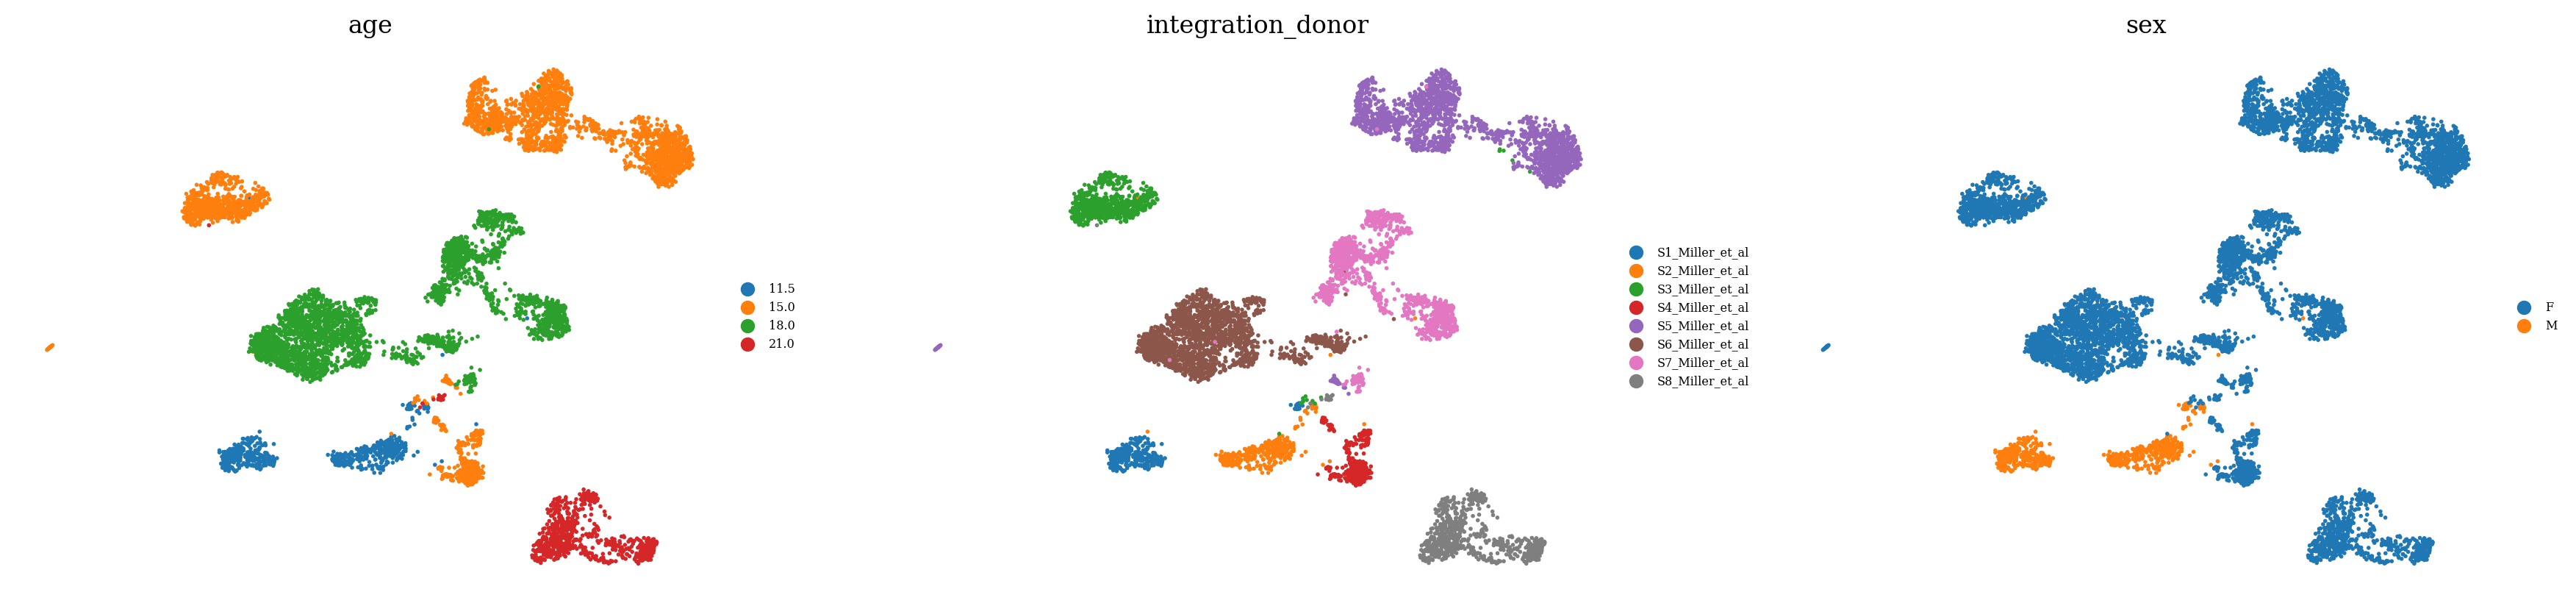

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

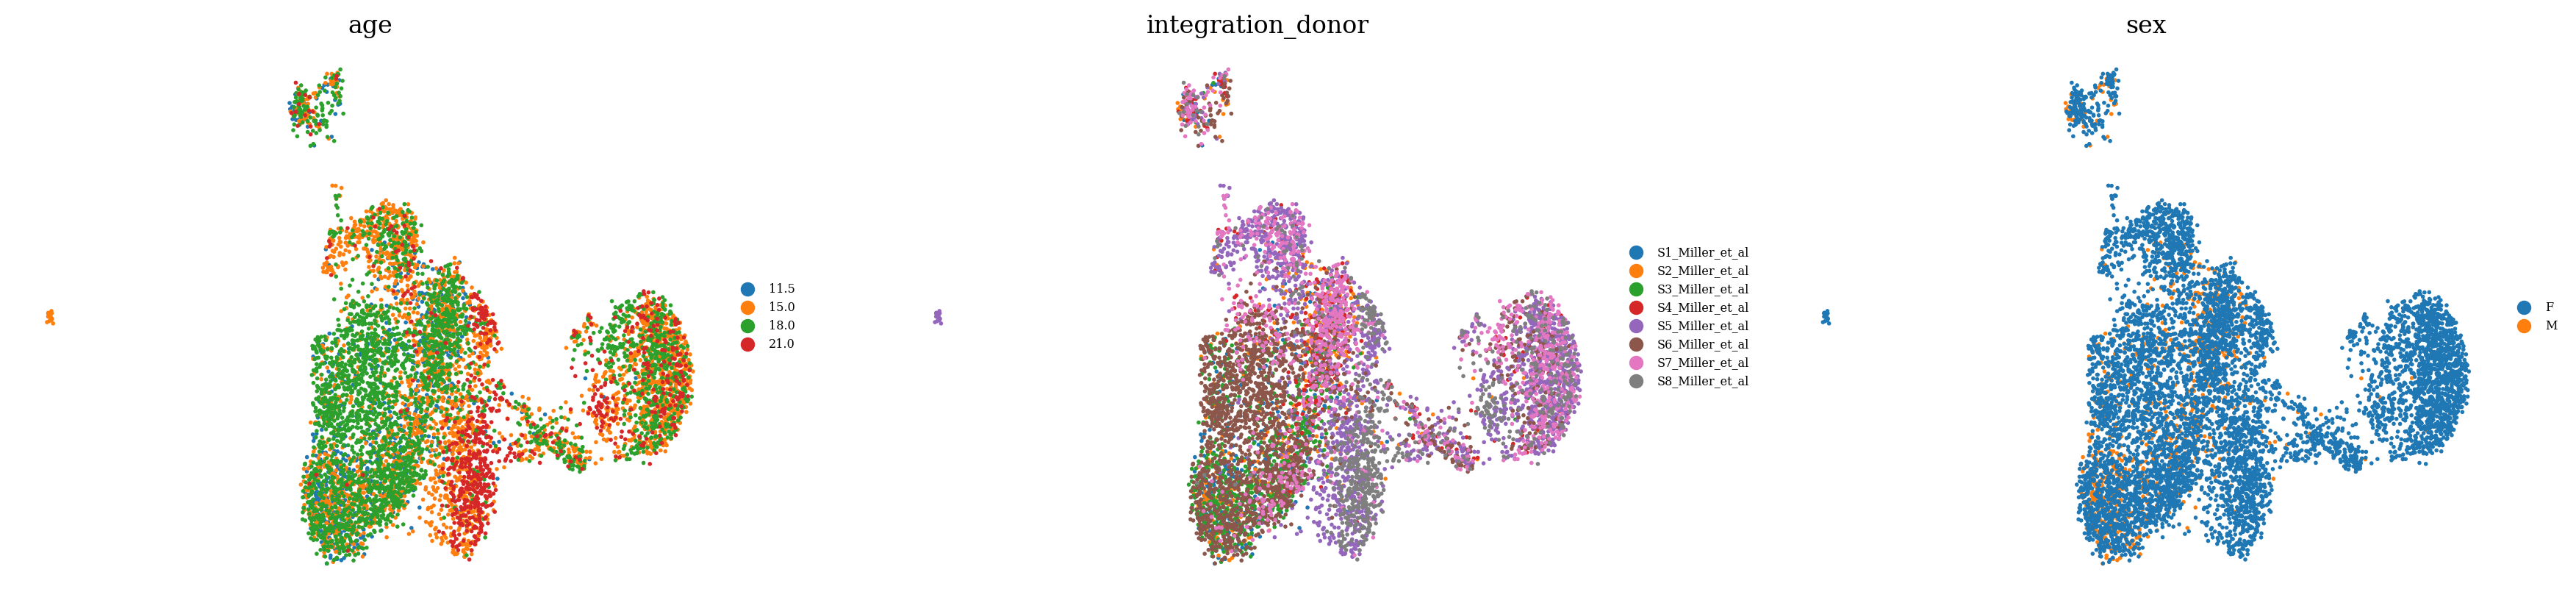

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  9%|▊         | 20/232 [00:00<00:01, 191.54it/s]

 18%|█▊        | 42/232 [00:00<00:00, 201.53it/s]

 27%|██▋       | 63/232 [00:00<00:00, 183.35it/s]

 35%|███▌      | 82/232 [00:00<00:00, 175.77it/s]

 43%|████▎     | 100/232 [00:00<00:00, 172.45it/s]

 51%|█████     | 118/232 [00:00<00:00, 170.31it/s]

 59%|█████▊    | 136/232 [00:00<00:00, 169.97it/s]

 66%|██████▋   | 154/232 [00:00<00:00, 169.05it/s]

 74%|███████▎  | 171/232 [00:00<00:00, 168.80it/s]

 81%|████████  | 188/232 [00:01<00:00, 168.33it/s]

 88%|████████▊ | 205/232 [00:01<00:00, 168.11it/s]

 96%|█████████▌| 222/232 [00:01<00:00, 167.22it/s]

100%|██████████| 232/232 [00:01<00:00, 171.86it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.559025066891794

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)